# Pipeline para análise de dados de RepSeq de cavalos imunizados com SARS-CoV-2

Esse notebook servirá como um descritivo das ações do pipeline, anotações etc., com possíveis análises de logs dos comandos.

O pipeline será realizado com os dados do projeto COVID, com os procedimentos de bancada realizados na UFMG.

Os arquivos originários do sequenciamento, armazenados na pasta rawData/sequenciamento2022/reads, estão em pastas seguindo o formato:

`(ID do cavalo [834|840|843|844])-(Situação [I: Imunizado|NI: Não Imunizado])-(Conjunto de primers [F|ORF])`

Dentro de cada pasta são encontrados 2 arquivos (pair reads) com nome seguindo o padrão

`(ID do cavalo [834|840|843|844])-(Situação [I: Imunizado|NI: Não Imunizado])-(Classe de primers [F:funcionais|ORF])_S1_L001_R[1|2]_001.fastq`

## Imports necessários às análises

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

## Definições gerais
Vamos criar as pastas necessárias para o notebook (fastas/, tables/, logs/) e definir as pastas padrão que serão utilizadas:

In [3]:
# Configuração inicial

# qual read deveremos transformar como reversa complementar? (tail,head,both,none)
rc_opt = 'tail'

# nome/caminho do arquivo de primers foward (dentro da pasta 'fastas/')
primer_foward = 'rawData/sequenciamento2022/primers/primers.fasta'
# nome/caminho do arquivo de primers reverse (dentro da pasta 'fastas/')
primer_reverse = 'rawData/sequenciamento2022/primers/primers.fasta'
# nome/caminho do arquivo de sequências R1 (dentro da pasta 'fastas/')
seq_r1 = 'rawData/sequenciamento2022/reads/840_I_F/840-I-F_S2_L001_R1_001.fastq'
# nome/caminho do arquivo de sequências R2 (dentro da pasta 'fastas/')
seq_r2 = 'rawData/sequenciamento2022/reads/840_I_F/840-I-F_S2_L001_R2_001.fastq'

# caminho de saída dos arquivos do pipeline
outdir = "analysis/840_I_F"
# nome do arquivo que será destino da montagem (dentro da pasta 'fastas/')
seq_mnt = '840_I_F'


# mínimo de qualidade que suas sequências devem ter
min_quality = 30

# a segunte tag será adicionada na verificação dos primers da região constante, caso necessário
primer_reverse_flag = '--revpr'

# localização absoluta do executável do blast
blastn_dir = '/doistb/opt/ncbi-blast-2.12.0+/bin'

# threads da máquina
n_threads = 20

# nome/caminho do arquivo de fasta de referência para o blastdb
reference_file = 'rawData/germlineRefGeneDB/equus_caballus.fasta'

vquest_dir = 'analysis/840_I_F/highv-quest'


os.makedirs(f"./{outdir}/presto/logs", exist_ok=True)
os.makedirs(f"./{outdir}/pipeline", exist_ok=True)
os.makedirs(f"./{outdir}/tables", exist_ok=True)
os.makedirs(f"./{vquest_dir}", exist_ok=True)

## Montagem das reads

Execução do *script* `AssemblePairs.py` do PRESTO com os valores *default* quando possível.

Parâmetros *default*:
* MIN_LEN: "Minimum sequence length to scan for overlap in de novo assembly"
* MAX_LEN: "Maximum sequence length to scan for overlap in de novo assembly."

Parâmetros informados:
* Ação: alinhar
* Arquivos contendo as reads (pair)
* Tipo de sequenciamento: Illumina
* Necessidade de geração de reverso complementar (--rc): utilizar o reverso complementar da read2 (tail)
* Pasta onde os arquivos de saída serão armazenados (--outdir): nome com o padrão da pasta das reads/presto
* Nome base dos arquivos de saída (--outname): nome com o padrão da pasta das reads
* Caminho para gravação do arquivo de log (--log): nome com o padrão da pasta das reads/presto/logs/AssemblePairs.log

Arquivos gerados:

* O arquivo /presto/logs/AssemblePairs.log contém cada uma das sequências do "contig" (SEQ1 e SEQ2) e o assembly com sua qualidade. Além disso, para cada um dos assemblies, é apresentado seu tamanho, o tamanho do overlap, o erro e o p-value.
* 2 arquivos de sequências que falharam com o padrão `(ID do cavalo [834|840|843|844])_(Situação [I: Imunizado|NI: Não Imunizado])_(Classe de primers [F:funcionais|ORF])-[1|2]_assemble-fail.fastq`
* Arquivo com as sequências montadas `(ID do cavalo [834|840|843|844])_(Situação [I: Imunizado|NI: Não Imunizado])_(Classe de primers [F:funcionais|ORF])_assemble-pass.fastq`

In [7]:
!AssemblePairs.py align -1 {seq_r1} -2 {seq_r2} --minlen 80 --maxerror 0.1 \
--coord illumina --rc {rc_opt} --outdir {outdir}/presto --outname {seq_mnt} \
--log {outdir}/presto/logs/AssemblePairs.log --failed

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
       START> AssemblePairs
     COMMAND> align
       FILE1> 840-I-F_S2_L001_R1_001.fastq
       FILE2> 840-I-F_S2_L001_R2_001.fastq
  COORD_TYPE> illumina
       ALPHA> 1e-05
   MAX_ERROR> 0.1
     MIN_LEN> 80
     MAX_LEN> 1000
SCAN_REVERSE> False
       NPROC> 20

PROGRESS> 13:22:28 |####################| 100% (1,227,601) 53.5 min

OUTPUT> 840_I_F_assemble-pass.fastq
 PAIRS> 1227601
  PASS> 1034421
  FAIL> 193180
   END> AssemblePairs



Fazer o parser do log de saída e formatá-lo como tabela (com todas as colunas disponíveis no arquivo de log):

In [8]:
!ParseLog.py -l {outdir}/presto/logs/AssemblePairs.log --outdir {outdir}/presto/logs \
--outname AssemblePairs -f ID LENGTH OVERLAP ERROR PVALUE

START> ParseLog
 FILE> AssemblePairs.log

PROGRESS> 13:23:00 (1227601) 0.5 min

 OUTPUT> AssemblePairs_table.tab
RECORDS> 1227601
   PASS> 1227601
   FAIL> 0
    END> ParseLog



Agora, vamos carregar esse csv para o notebook:

In [9]:
assembled = pd.read_table(f'{outdir}/presto/logs/AssemblePairs_table.tab')
assembled.describe()

,LENGTH,OVERLAP,ERROR,PVALUE
count,1.226927e+06,1.226927e+06,1.226927e+06,1.226927e+06
mean,4.287378e+02,1.681137e+02,5.972583e-02,1.262954e-03
std,4.719024e+01,3.377181e+01,9.851713e-02,3.294545e-02
min,8.500000e+01,8.000000e+01,0.000000e+00,-2.072500e-17
25%,4.260000e+02,1.490000e+02,1.030000e-02,-3.712100e-75
50%,4.410000e+02,1.590000e+02,2.580000e-02,-1.642200e-86
75%,4.530000e+02,1.730000e+02,6.330000e-02,-1.140900e-97
max,5.220000e+02,3.010000e+02,1.000000e+00,1.000000e+00


In [10]:
assembled[assembled['PVALUE'] >= 0].sort_values('PVALUE')

,ID,LENGTH,OVERLAP,ERROR,PVALUE
962707,M02832:47:000000000-K3JFG:1:2112:7681:13736,516.0,86.0,0.3256,4.642800e-17
776839,M02832:47:000000000-K3JFG:1:2106:22985:24649,516.0,86.0,0.3256,4.642800e-17
893161,M02832:47:000000000-K3JFG:1:2110:16062:12847,516.0,86.0,0.3256,4.642800e-17
678284,M02832:47:000000000-K3JFG:1:2104:17304:2313,450.0,150.0,0.4333,4.884800e-17
1057705,M02832:47:000000000-K3JFG:1:2115:22603:8070,452.0,150.0,0.4333,4.884800e-17
...,...,...,...,...,...
810504,M02832:47:000000000-K3JFG:1:2108:20665:2258,317.0,285.0,0.8632,1.000000e+00
810495,M02832:47:000000000-K3JFG:1:2108:19556:2141,520.0,80.0,0.9500,1.000000e+00
810473,M02832:47:000000000-K3JFG:1:2108:10784:2261,518.0,82.0,0.9390,1.000000e+00
612658,M02832:47:000000000-K3JFG:1:2102:16422:2222,522.0,80.0,0.9625,1.000000e+00


__Análise do tamanho da sequência gerada pela montagem__

As sequências devem ter o tamanho esperado para os amplicons após a remoção dos adaptadores.

<Axes: >

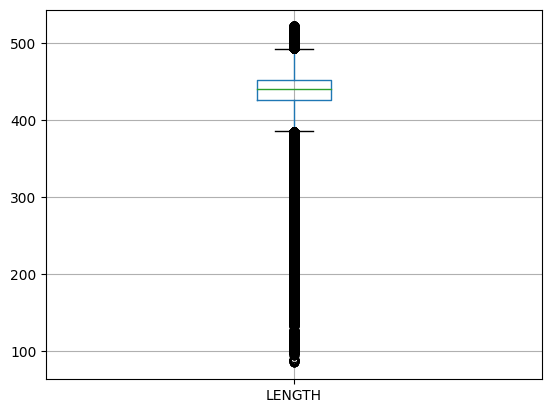

In [11]:
assembled.boxplot(column=['LENGTH'], return_type=None)

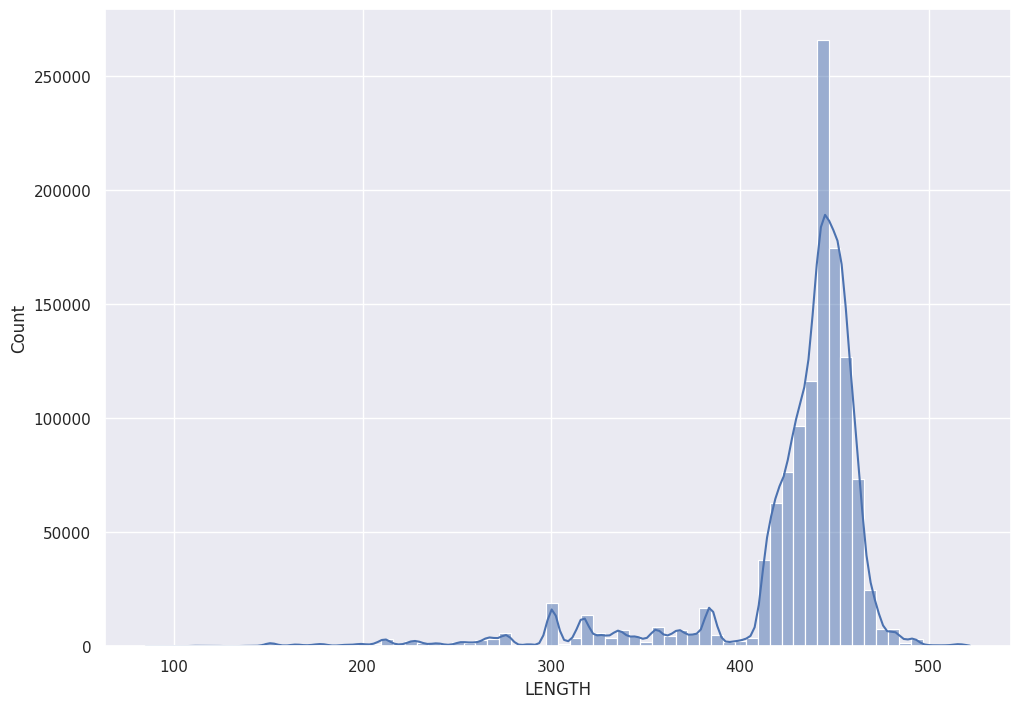

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(assembled['LENGTH'], kde=True, bins=70)
plt.show()

__Análise do tamanho da sobreposição das reads após a montagem__

Os amplicons com sobreposição grande provavelmente correspondem aos amplicons que tiveram tamanho menor no gráfico anterior.

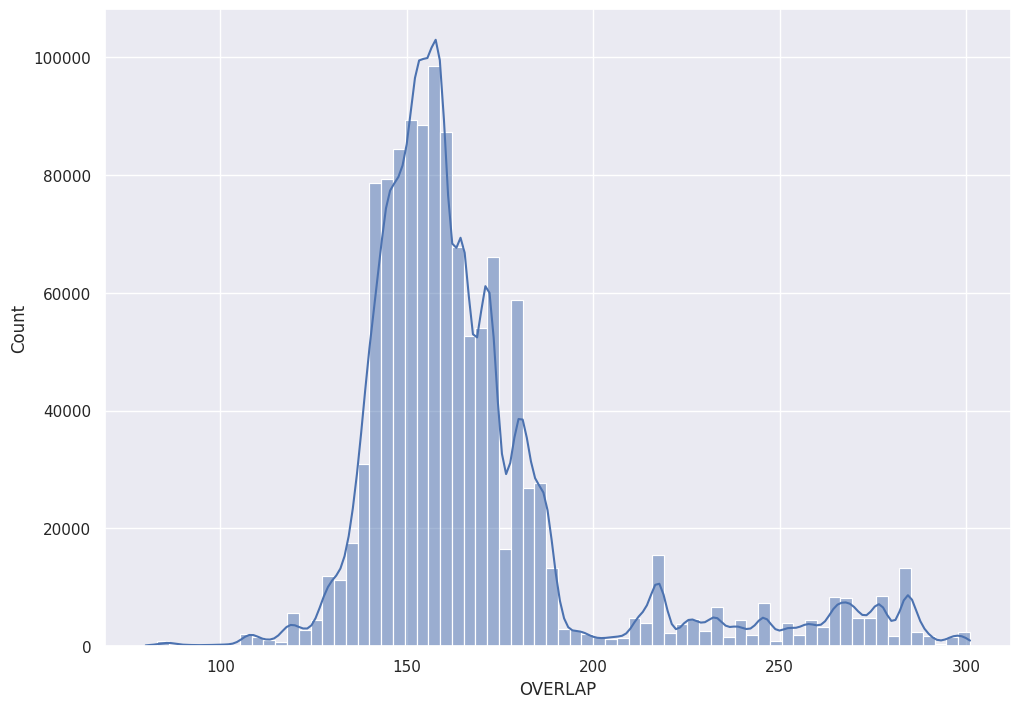

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(assembled['OVERLAP'], kde=True, bins=70)
plt.show()

## Filtro das reads

__Filtro de qualidade__

Após a montagem, foi realizado o filtro de qualidade mantendo sequências que tenham Phred score médio maior ou igual a 30. 

In [14]:
!FilterSeq.py quality -s "{outdir}/presto/{seq_mnt}_assemble-pass.fastq" -q 30 --outname {seq_mnt}_q{min_quality} \
--outdir {outdir}/presto --log "{outdir}/presto/logs/Quality.log" --failed

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
   START> FilterSeq
 COMMAND> quality
    FILE> 840_I_F_assemble-pass.fastq
   INNER> False
MIN_QUAL> 30.0
   NPROC> 20

PROGRESS> 13:27:22 |####################| 100% (1,034,421) 4.0 min

   OUTPUT> 840_I_F_q30_quality-pass.fastq
SEQUENCES> 1034421
     PASS> 904668
     FAIL> 129753
      END> FilterSeq



<div class="alert alert-block alert-warning">
Gerar o histograma de qualidade das bases e sequências para determinar o cut off
</div>

In [15]:
!ParseLog.py -l "{outdir}/presto/logs/Quality.log" --outdir "{outdir}/presto/logs" --outname Quality -f ID QUALITY

START> ParseLog
 FILE> Quality.log

PROGRESS> 13:27:38 (1034421) 0.2 min

 OUTPUT> Quality_table.tab
RECORDS> 1034421
   PASS> 1034421
   FAIL> 0
    END> ParseLog



In [16]:
quality = pd.read_table(f'./{outdir}/presto/logs/Quality_table.tab')
quality.describe()

,QUALITY
count,1.034421e+06
mean,3.443171e+01
std,4.093815e+00
min,1.200000e+01
25%,3.300000e+01
50%,3.600000e+01
75%,3.700000e+01
max,3.800000e+01


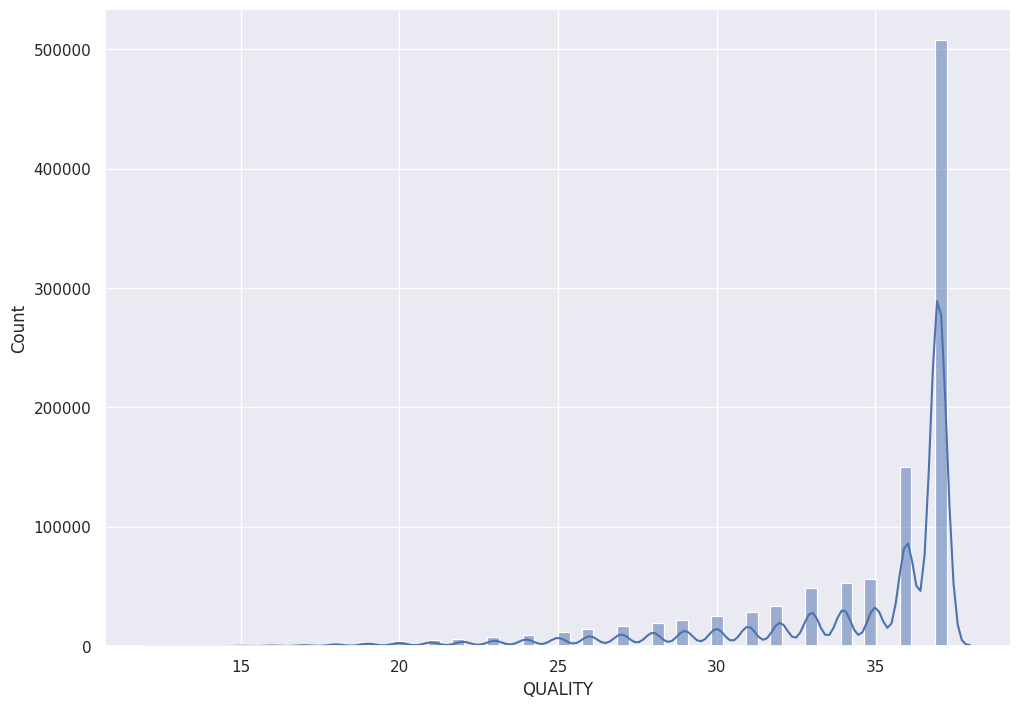

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(quality['QUALITY'], kde=True, bins=70)
plt.show()

__Filtro/identificação dos primers__

<div class="alert alert-block alert-info">
    - Qual dos 2 foi realmente utilizado?
    <br>
    - Acho melhor fazer somente com os primers funcionais, já que a princípio são os primers que foram utilizados na PCR. Depois a gente faz a análise que combinamos para verificar a sobreposição de primers
</div>

In [18]:
!MaskPrimers.py align -s "{outdir}/presto/{seq_mnt}_q{min_quality}_quality-pass.fastq" -p "{primer_foward}" \
--mode tag --outname "{seq_mnt}_q{min_quality}-primer-FW" --log "{outdir}/presto/logs/MaskPrimers-FW.log" --failed \
--maxerror 0.5 --outdir {outdir}/presto --pf VPRIMER

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
       START> MaskPrimers
     COMMAND> align
    SEQ_FILE> 840_I_F_q30_quality-pass.fastq
 PRIMER_FILE> primers.fasta
        MODE> tag
   MAX_ERROR> 0.5
     MAX_LEN> 50
  REV_PRIMER> False
     SKIP_RC> False
 GAP_PENALTY> 1, 1
     BARCODE> False
PRIMER_FIELD> VPRIMER
       NPROC> 20

PROGRESS> 13:51:34 |####################| 100% (904,668) 23.7 min

   OUTPUT> 840_I_F_q30-primer-FW_primers-pass.fastq
SEQUENCES> 904668
     PASS> 904668
     FAIL> 0
      END> MaskPrimers



In [19]:
!MaskPrimers.py align -s "{outdir}/presto/{seq_mnt}_q{min_quality}-primer-FW_primers-pass.fastq" \
-p "{primer_reverse}" --mode tag --outname "{seq_mnt}_q{min_quality}-primer-RV" \
--outdir {outdir}/presto --log "{outdir}/presto/logs/MaskPrimers-REV.log" {primer_reverse_flag} --failed \
--maxerror 0.5 --pf CPRIMER

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
       START> MaskPrimers
     COMMAND> align
    SEQ_FILE> 840_I_F_q30-primer-FW_primers-pass.fastq
 PRIMER_FILE> primers.fasta
        MODE> tag
   MAX_ERROR> 0.5
     MAX_LEN> 50
  REV_PRIMER> True
     SKIP_RC> False
 GAP_PENALTY> 1, 1
     BARCODE> False
PRIMER_FIELD> CPRIMER
       NPROC> 20

PROGRESS> 14:14:04 |####################| 100% (904,668) 22.4 min

   OUTPUT> 840_I_F_q30-primer-RV_primers-pass.fastq
SEQUENCES> 904668
     PASS> 904668
     FAIL> 0
      END> MaskPrimers



In [20]:
!ParseLog.py -l "{outdir}/presto/logs/MaskPrimers-REV.log" "{outdir}/presto/logs/MaskPrimers-FW.log" \
--outdir "{outdir}/presto/logs" -f ID PRIMER ERROR

START> ParseLog
 FILE> MaskPrimers-REV.log

PROGRESS> 14:14:14 (904668) 0.2 min

 OUTPUT> MaskPrimers-REV_table.tab
RECORDS> 904668
   PASS> 904668
   FAIL> 0
    END> ParseLog

START> ParseLog
 FILE> MaskPrimers-FW.log

PROGRESS> 14:14:23 (904668) 0.1 min

 OUTPUT> MaskPrimers-FW_table.tab
RECORDS> 904668
   PASS> 904668
   FAIL> 0
    END> ParseLog



In [21]:
primers_tb = pd.read_table(outdir + '/presto/logs/MaskPrimers-FW_table.tab')


In [22]:
primers_tb['PRIMER'].value_counts()

PRIMER
hoHV2_4f             561366
hoHV4f               255194
hoHV1f                63558
_NovoPseudoeORF10      6502
hoHV6S1f               5005
hoHV7S1f               4034
_NovoPseudoeORF4       3324
_NovoPseudoeORF12      1479
_NovoF3                1373
_NovoPseudoeORF28      1236
_NovoPseudoeORF9        779
_NovoPseudoeORF24       592
hoHV4S17f                53
_NovoPseudoeORF11        44
_NovoPseudoeORF8         43
_NovoPseudoeORF17        20
hoHV1S6f                 19
_NovoF2                  10
_NovoPseudoeORF7          8
_NovoPseudoeORF19         8
_NovoPseudoeORF14         8
_NovoPseudoeORF13         7
_NovoPseudoeORF16         4
_NovoPseudoeORF15         1
_NovoPseudoeORF5          1
Name: count, dtype: int64

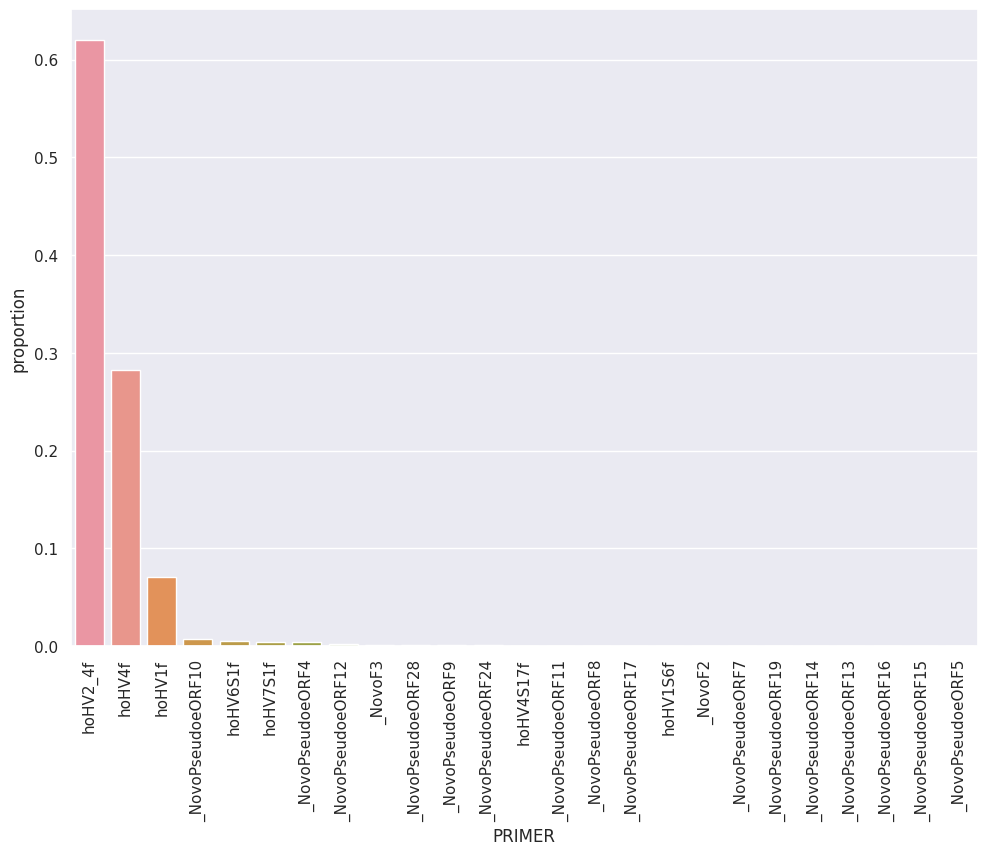

In [23]:
sns.barplot(x=primers_tb['PRIMER'].value_counts(normalize=True).index, y=primers_tb['PRIMER'].value_counts(normalize=True))
plt.xticks(rotation=90)
plt.show()

Agora vamos descartar as sequências que possuem menos de 100 nucleotídeos

In [24]:
!FilterSeq.py length -s "{outdir}/presto/{seq_mnt}_q{min_quality}-primer-RV_primers-pass.fastq" -n 100 \
--outname "{seq_mnt}_q{min_quality}-primer-RV" --outdir {outdir}/presto --failed --log "{outdir}/presto/logs/FilterSeqLen.log"

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
     START> FilterSeq
   COMMAND> length
      FILE> 840_I_F_q30-primer-RV_primers-pass.fastq
     INNER> False
MIN_LENGTH> 100
     NPROC> 20

PROGRESS> 14:17:29 |####################| 100% (904,668) 3.0 min

   OUTPUT> 840_I_F_q30-primer-RV_length-pass.fastq
SEQUENCES> 904668
     PASS> 904621
     FAIL> 47
      END> FilterSeq



In [25]:
!ParseLog.py -l "{outdir}/presto/logs/FilterSeqLen.log" --outdir "{outdir}/presto/logs" --outname FilterSeqLen -f ID LENGTH

START> ParseLog
 FILE> FilterSeqLen.log

PROGRESS> 14:17:36 (904668) 0.1 min

 OUTPUT> FilterSeqLen_table.tab
RECORDS> 904668
   PASS> 904668
   FAIL> 0
    END> ParseLog



E, por fim, colapsar as sequências repetidas, primeiro verificando as que tem como obrigatoriedade o mesmo primer da região Constante e com até 20 nucleotídeos diferentes em qualquer extremidade:

In [26]:
!CollapseSeq.py -s "{outdir}/presto/{seq_mnt}_q{min_quality}-primer-RV_length-pass.fastq" -n 20 --inner --uf CPRIMER \
--cf VPRIMER --act set --outname "{seq_mnt}_q{min_quality}-primer-RV" --outdir {outdir}/presto

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
       START> CollapseSeq
        FILE> 840_I_F_q30-primer-RV_length-pass.fastq
 MAX_MISSING> 20
 UNIQ_FIELDS> CPRIMER
 COPY_FIELDS> VPRIMER
COPY_ACTIONS> set
   MAX_FIELD> None
   MIN_FIELD> None
       INNER> True
KEEP_MISSING> False

PROGRESS> [0 missing] 14:18:23 |####################| 100% (904,621) 0.2 min

      OUTPUT> 840_I_F_q30-primer-RV_collapse-unique.fastq
   SEQUENCES> 904621
      UNIQUE> 521853
   DUPLICATE> 382768
UNDETERMINED> 0
         END> CollapseSeq



A saída deste programa contém 3 arquivos:
- collapse-unique: contains one representative from each set of duplicate sequences. The retained representative is determined by user defined criteria.

- collapse-duplicate: raw reads which are duplicates of the sequences retained in the collapse-unique file.

- collapse-undetermined: raw reads which were excluded from consideration due to having too many N characters in the sequence.

Aqui separamos as sequências que possuem pelo menos 2 duplicatas (i.e, não são únicas)

Gerar gráfico de primers depois da redundância

In [27]:
!SplitSeq.py group -s"{outdir}/presto/{seq_mnt}_q{min_quality}-primer-RV_collapse-unique.fastq" -f DUPCOUNT --num 2 \
--outname "{seq_mnt}_q{min_quality}-primer-RV" --outdir {outdir}/presto

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
    START> SplitSeq
  COMMAND> group
     FILE> 840_I_F_q30-primer-RV_collapse-unique.fastq
    FIELD> DUPCOUNT
THRESHOLD> 2.0

PROGRESS> 14:19:33 |####################| 100% (521,853) 0.5 min

  OUTPUT1> 840_I_F_q30-primer-RV_under-2.fastq
  OUTPUT2> 840_I_F_q30-primer-RV_atleast-2.fastq
SEQUENCES> 521853
    PARTS> 2
      END> SplitSeq



# Sequências perdidas

Esses dados precisam ser colocados manualmente no dataframe


In [28]:
losses = pd.DataFrame({'label':['Total', 'AssemblePairs', 'FilterSeqQual', 'MaskPrimers', 'FilterSeqLen'],
                       'fail': [1227601, 193180, 129753, 0, 47],
                       'pass': [1227601, 1034421, 904668, 904668, 904621]})
losses

,label,fail,pass
0,Total,1227601,1227601
1,AssemblePairs,193180,1034421
2,FilterSeqQual,129753,904668
3,MaskPrimers,0,904668
4,FilterSeqLen,47,904621


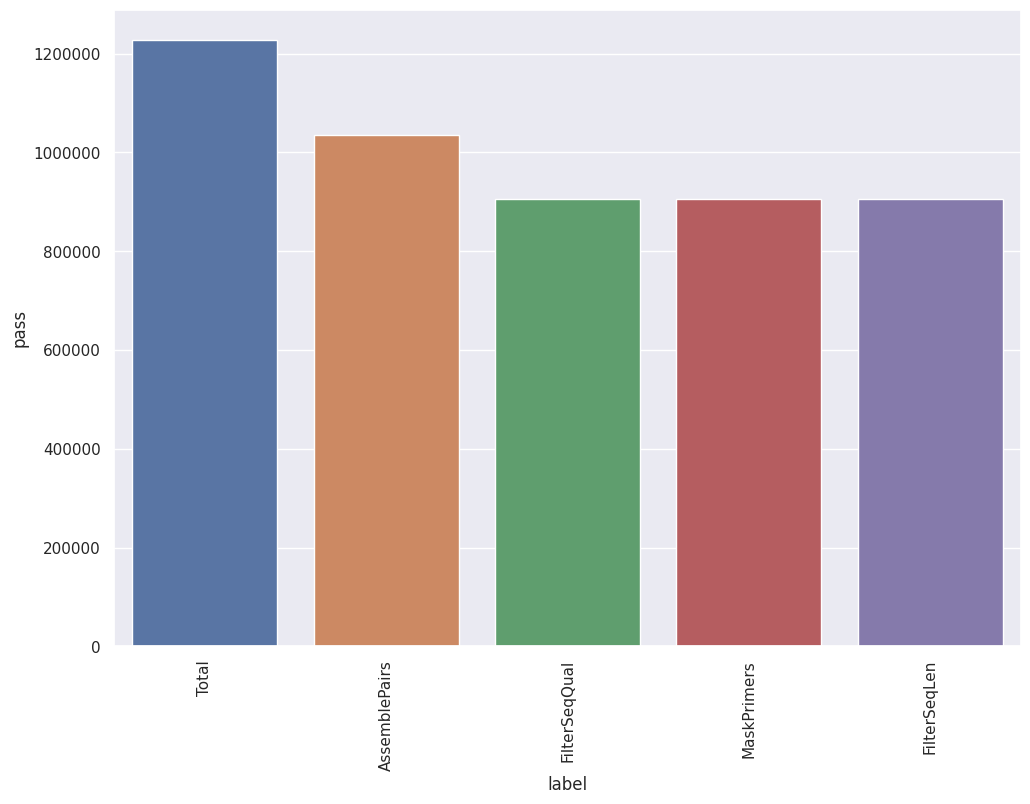

In [29]:
sns.barplot(x='label', y='pass', data=losses)
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [30]:
!sed -n '1~4s/^@/>/p;2~4p' {outdir}/presto/{seq_mnt}_q{min_quality}-primer-RV_collapse-unique.fastq > \
    {outdir}/presto/{seq_mnt}_q{min_quality}-primer-RV_collapse-unique.fasta

Também fizemos a anotação usando o HighV-Quest, e os resultados estão na pasta "v-quest".

Primeiro, vamos ver a quantidade de sequências produtivas, improdutivas e sem resultados

# Sequências produtivas, improdutivas e sem resultados

In [79]:
df_vquest = pd.read_table(vquest_dir + '/4_IMGT-gapped-AA-sequences.txt', index_col=0)
df_vquest

/tmp/ipykernel_11706/2686505447.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vquest = pd.read_table(vquest_dir + '/4_IMGT-gapped-AA-sequences.txt', index_col=0)


,Sequence ID,V-DOMAIN Functionality,V-GENE and allele,J-GENE and allele,D-GENE and allele,V-D-J-REGION,V-J-REGION,V-REGION,FR1-IMGT,CDR1-IMGT,FR2-IMGT,CDR2-IMGT,FR3-IMGT,CDR3-IMGT,JUNCTION,J-REGION,FR4-IMGT
Sequence number,,,,,,,,,,,,,,,,,
1,M02832:47:000000000-K3JFG:1:1101:13286:2207|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ4*01 F,Equcab IGHD2-29*01 F,QVQLKESGP.GLVKPSQTLSLTCTVSAFSL....SSYGVNWVRQAP...,NaN,QVQLKESGP.GLVKPSQTLSLTCTVSAFSL....SSYGVNWVRQAP...,QVQLKESGP.GLVKPSQTLSLTCTVS,AFSL....SSYG,VNWVRQAPGKGLEFVAT,ITDS...GGK,FYNPALK.SRASITKDT.SKSQVYLALNSLTSEDTAVYYC,AGGGSIWGYYYDY,CAGGGSIWGYYYDYW,YWGQGILVTVSS,WGQGILVTVSS
2,M02832:47:000000000-K3JFG:1:1101:13494:2227|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ4*01 F,Equcab IGHD2-6*01 F,QVQLKESGP.GLVKPSQTLSLTCTVSGLSL....SSNSVGWVRQAP...,NaN,QVQLKESGP.GLVKPSQTLSLTCTVSGLSL....SSNSVGWVRQAP...,QVQLKESGP.GLVKPSQTLSLTCTVS,GLSL....SSNS,VGWVRQAPGKGLQYVGL,TLKS...GGV,VYNPALK.SRASITKDT.SKSQVYLTLNSLTSEDTAVYYC,VGDMVTSLGVADFVY,CVGDMVTSLGVADFVYW,FVYWGQGTLVTVSS,WGQGTLVTVSS
3,M02832:47:000000000-K3JFG:1:1101:9844:2245|SEQORI,unproductive,Equcab IGHV4-22*01 F,Equcab IGHJ4*01 F,Equcab IGHD4-2*01 F,QVQLKETGA.GQVKPSHTPSRACIRATFSV....SRYVENWVRQAP...,NaN,QVQLKETGA.GQVKPSHTPSRACIRATFSV....SRYVENWVRQAP...,QVQLKETGA.GQVKPSHTPSRACIRA,TFSV....SRYV,ENWVRQAPGK.......,..........,....VRQ.APG...KDN.*ED*HSVTKHSFSGEDTAVF*C,GNGDGMSTRIIGGL,CGNGDGMSTRIIGGLL,LLAPGYPGHRVL,WRQGILVIVSS
4,M02832:47:000000000-K3JFG:1:1101:21814:2212|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ6-1*01 F,Equcab IGHD4-11*01 F,QVQLKESGP.GLVKPSQTLSLTCTVSGFSW....SRDGVGWVRQAP...,NaN,QVQLKESGP.GLVKPSQTLSLTCTVSGFSW....SRDGVGWVRQAP...,QVQLKESGP.GLVKPSQTLSLTCTVS,GFSW....SRDG,VGWVRQAPGKGLEFVGG,IDSS...ESA,HYNPALK.SRASITKDT.SKSLVYLTLNSLTSEDTADYYC,TGGSPDNNWGYVIYGETY,CTGGSPDNNWGYVIYGETYW,YWGQGILVTVSS,WGQGILVTVSS
5,M02832:47:000000000-K3JFG:1:1101:19851:2230|SEQOR,productive,"Equcab IGHV4-22*01 F, or Equcab IGHV4-29*02 F",Equcab IGHJ6-1*01 F,Equcab IGHD2-18*01 F,QVQLKESGP.GLVKPSQTLSLTCSVSGFSL....SDYAVDWVRQAP...,NaN,QVQLKESGP.GLVKPSQTLSLTCSVSGFSL....SDYAVDWVRQAP...,QVQLKESGP.GLVKPSQTLSLTCSVS,GFSL....SDYA,VDWVRQAPGKGLEGVGD,IDGV...GSE,DYNPALK.SRASITTDV.AKSQVYLKLAGVTDEDTAVYFC,ARWGYERSAGSYYDGIVY,CARWGYERSAGSYYDGIVYW,YWGQGIPVIVSS,WGQGIPVIVSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904617,M02832:47:000000000-K3JFG:1:2119:19699:25284|SEQO,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ6-1*01 F,Equcab IGHD3-10*02 ORF,QVQLKESGP.GLVKPSQTLSLTCTVSGFPL....SDYGVIWVRQAP...,NaN,QVQLKESGP.GLVKPSQTLSLTCTVSGFPL....SDYGVIWVRQAP...,QVQLKESGP.GLVKPSQTLSLTCTVS,GFPL....SDYG,VIWVRQAPGKGLEFVGS,MSPT...GSV,KYNQSLK.SRASITRDT.EKSQVYLTLNSLTSEDTAVYYC,AGGSKWYYTFAYEDYGATRN,CAGGSKWYYTFAYEDYGATRNW,WGEGILVIVSS,WGEGILVIVSS
904618,M02832:47:000000000-K3JFG:1:2119:11599:25211|SEQO,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ6-1*01 F,Equcab IGHD2-18*01 F,QVQLKESGP.GLVKPSQTLSLTCTVSGFSL....RGYGVGWVRQAP...,NaN,QVQLKESGP.GLVKPSQTLSLTCTVSGFSL....RGYGVGWVRQAP...,QVQLKESGP.GLVKPSQTLSLTCTVS,GFSL....RGYG,VGWVRQAPGKGLEFVGG,SVSS...GSA,NYNPALK.SRASITKDT.SKSQVYLTLNSLTSEDTAVYYC,AGYGLYTGSYYPLRINY,CAGYGLYTGSYYPLRINYW,INYWGQGILVTVSS,WGQGILVTVSS
904619,M02832:47:000000000-K3JFG:1:2119:13246:25292|SEQO,productive,Equcab IGHV4-29*01 F,Equcab IGHJ6-1*01 F,Equcab IGHD7-43*01 ORF,QVQLKESGP.GLVKPSQTLSLICTVSGLNL....REDNVGWVRQAP...,NaN,QVQLKESGP.GLVKPSQTLSLICTVSGLNL....REDNVGWVRQAP...,QVQLKESGP.GLVKPSQTLSLICTVS,GLNL....REDN,VGWVRQAPGKGLEYVGL,IFDS...ITR,NYNPALK.SRASVTKDT.PKTQVYLTLNSLTRDDTAVYFC,VGQLHVSVGQTY,CVGQLHVSVGQTYW,YWGQGVLVTVSS,WGQGVLVTVSS


In [80]:
df_vquest['V-DOMAIN Functionality'].value_counts()

V-DOMAIN Functionality
productive                                     771379
No results                                      85791
unproductive                                    23799
No rearrangement found                          23630
rearranged sequence (but no junction found)        22
Name: count, dtype: int64

In [4]:
df_vquest['V-DOMAIN Functionality'].value_counts(normalize=True)

V-DOMAIN Functionality
productive                                     0.852710
No results                                     0.094836
unproductive                                   0.026308
No rearrangement found                         0.026121
rearranged sequence (but no junction found)    0.000024
Name: proportion, dtype: float64

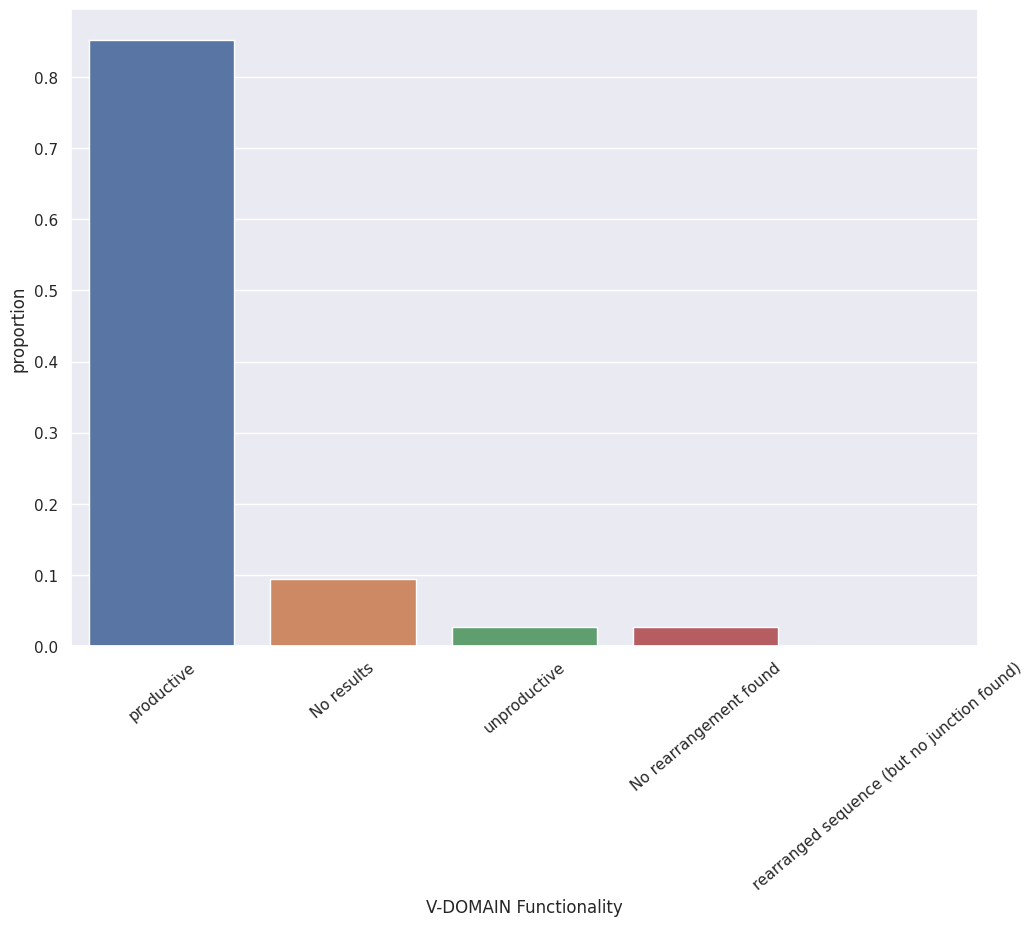

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x=df_vquest['V-DOMAIN Functionality'].value_counts(normalize=True).index,
            y=df_vquest['V-DOMAIN Functionality'].value_counts(normalize=True))

plt.xticks(rotation=40)
plt.show()

# Verificação de quais genes V, D e J foram utilizados nas sequências

In [6]:
df_vquest['V-GENE and allele'].replace({',':''}, regex=True, inplace=True)
df_vquest['D-GENE and allele'].replace({',':''}, regex=True, inplace=True)
df_vquest['J-GENE and allele'].replace({',':''}, regex=True, inplace=True)

## "Força bruta" para definir os genes

In [ ]:
v_genes_expanded = pd.Series(data=None, dtype="object")
d_genes_expanded = pd.Series(data=None, dtype="object")
j_genes_expanded = pd.Series(data=None, dtype="object")

for row in df_vquest.iloc:
    if type(row['V-GENE and allele']) is str:
        
        v_genes_expanded = pd.concat([
            v_genes_expanded,
            pd.Series(
                [re.sub(r'(\*..)', '', i) for i in row['V-GENE and allele'].split(' or ')]
            )
        ])

    if type(row['D-GENE and allele']) is str:
        
        d_genes_expanded = pd.concat([
            d_genes_expanded,
            pd.Series(
                [re.sub(r'(\*..)', '', i) for i in row['D-GENE and allele'].split(' or ')]
            )
        ])

    if type(row['J-GENE and allele']) is str:
        
        j_genes_expanded = pd.concat([
            j_genes_expanded,
            pd.Series(
                [re.sub(r'(\*..)', '', i) for i in row['J-GENE and allele'].split(' or ')]
            )
        ])
        

In [ ]:
v_genes_expanded

In [ ]:
v_genes_expanded.value_counts()

In [ ]:
df_genes2 = pd.DataFrame({'Sequence number': [], 'v_genes': [], 'd_genes': [], 'j_genes': []})

for row in df_vquest.iloc:
# V-Gene cleanup
    if type(row['V-GENE and allele']) is str:
        v_genes = [
            re.sub(r'(\*..)', '', i) for i in row['V-GENE and allele'].split(' or ')
        ]
        
        for gene in v_genes_expanded.value_counts().index:
            if gene in v_genes:
                v_gene = gene
                break
    else:
        v_gene = np.nan
        
# D-Gene cleanup
    if type(row['D-GENE and allele']) is str:
        d_genes = [
            re.sub(r'(\*..)', '', i) for i in row['D-GENE and allele'].split(' or ')
        ]
        
        for gene in d_genes_expanded.value_counts().index:
            if gene in d_genes:
                d_gene = gene
                break
    else:
        d_gene = np.nan

# J-Gene cleanup
    if type(row['J-GENE and allele']) is str:
        j_genes = [
            re.sub(r'(\*..)', '', i) for i in row['J-GENE and allele'].split(' or ')
        ]
        
        for gene in j_genes_expanded.value_counts().index:
            if gene in j_genes:
                j_gene = gene
                break
    else:
        j_gene = np.nan

# Concating data
    df_aux = pd.DataFrame({
        'Sequence number': row['Sequence ID'],
        'v_genes': [v_gene],
        'd_genes': [d_gene],
        'j_genes': [j_gene]
    })
        
    df_genes2 = pd.concat([df_genes2, df_aux], ignore_index=True, axis=0)


In [ ]:
df_genes2.to_csv(outdir + '/pipeline/genes_expanded_bf.csv', sep=';')

## Resultados com o algoritmo "força bruta"

In [3]:
df_genes2 = pd.read_csv(outdir + '/pipeline/genes_expanded_bf.csv', sep=';')

In [81]:
def extract_and_count(column):
    # Extrair o trecho desejado
    extracted = column.str.extract(r'\s(IGH[^-]*)')[0]
    # Calcular value_counts(normalize=True)
    counts = extracted.value_counts(normalize=True)
    return counts

# Aplicar a função para cada coluna e salvar os resultados
v_genes_counts = extract_and_count(df_genes2['v_genes'])
d_genes_counts = extract_and_count(df_genes2['d_genes'])
j_genes_counts = extract_and_count(df_genes2['j_genes'])

# Exibir os resultados
print("Contagens normalizadas para v_genes:")
print(v_genes_counts)

print("\nContagens normalizadas para d_genes:")
print(d_genes_counts)

print("\nContagens normalizadas para j_genes:")
print(j_genes_counts)

Contagens normalizadas para v_genes:
0
IGHV4        0.913466
IGHV4S1 F    0.063938
IGHV1        0.019519
IGHV9        0.002797
IGHV5        0.000202
IGHV7        0.000066
IGHV3        0.000012
Name: proportion, dtype: float64

Contagens normalizadas para d_genes:
0
IGHD2    0.555474
IGHD4    0.193906
IGHD3    0.192042
IGHD6    0.025807
IGHD7    0.018818
IGHD1    0.013952
Name: proportion, dtype: float64

Contagens normalizadas para j_genes:
0
IGHJ6        0.606319
IGHJ4 F      0.252971
IGHJ3 F      0.079215
IGHJ5 F      0.050216
IGHJ1 ORF    0.006174
IGHJ2 ORF    0.005105
Name: proportion, dtype: float64


In [4]:
df_genes2['v_genes'].value_counts(normalize=True)

v_genes
Equcab IGHV4-21 ORF    0.335171
Equcab IGHV4-29 F      0.308406
Equcab IGHV4-22 F      0.166779
Equcab IGHV4-82 F      0.066753
Equcab IGHV4S1 F       0.063906
Equcab IGHV1-70 F      0.018839
Equcab IGHV4-65 F      0.017569
Equcab IGHV4-37 F      0.005635
Equcab IGHV4-37N F     0.004934
Equcab IGHV4-75 F      0.003203
Equcab IGHV9-66 F      0.002795
Equcab IGHV4-37D F     0.001931
Equcab IGHV4-17 F      0.001610
Equcab IGHV1-41 F      0.000445
Equcab IGHV4-55 F      0.000352
Equcab IGKV4-27 P      0.000307
Equcab IGHV4-52 P      0.000249
Equcab IGHV4-42 ORF    0.000233
Equcab IGHV1-5 F       0.000225
Equcab IGHV5-67 ORF    0.000202
Equcab IGHV4-59 F      0.000098
Equcab IGKV4-18 F      0.000076
Equcab IGHV4-11 F      0.000068
Equcab IGHV7-34 P      0.000066
Equcab IGKV4-31 P      0.000040
Equcab IGKV4-1 F       0.000024
Equcab IGKV4-5-1 F     0.000020
Equcab IGKV4-9-1 F     0.000015
Equcab IGHV4-35 P      0.000013
Equcab IGKV2-46 F      0.000011
Equcab IGHV3-78 F      0.000009


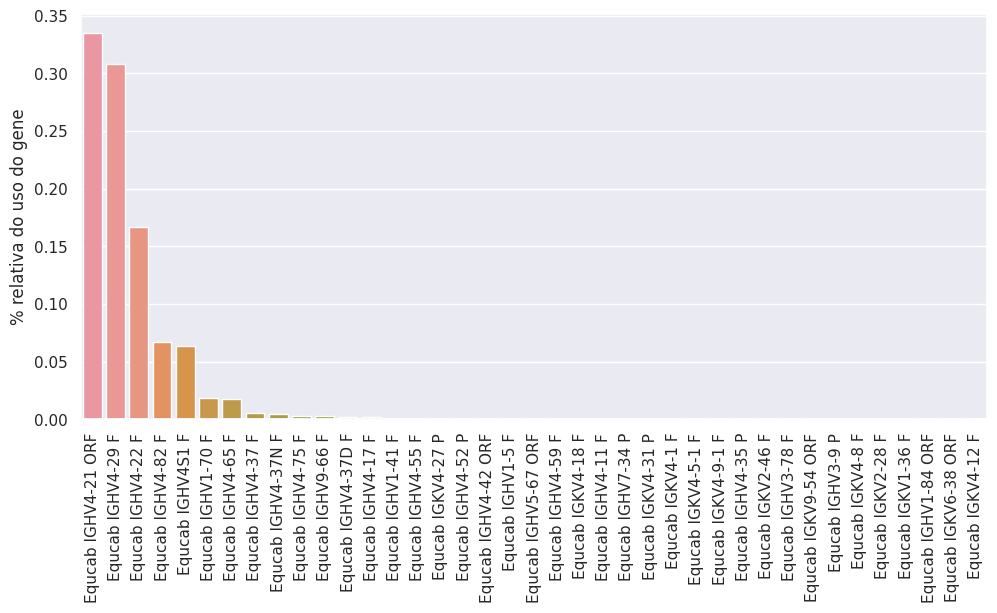

In [5]:
sns.set(rc={'figure.figsize':(11.7,5.27)})

ax = sns.barplot(x=df_genes2['v_genes'].value_counts(normalize=True).index, y=df_genes2['v_genes'].value_counts(normalize=True))
ax.set(xlabel='', ylabel='% relativa do uso do gene')

plt.xticks(rotation=90)
plt.show()

In [6]:
df_genes2['d_genes'].value_counts(normalize=True)

d_genes
Equcab IGHD2-26 F      0.101304
Equcab IGHD4-11 F      0.068448
Equcab IGHD2-3 ORF     0.066446
Equcab IGHD2-29 F      0.054608
Equcab IGHD2-12 F      0.053119
Equcab IGHD2-9 F       0.050830
Equcab IGHD2-18 F      0.047673
Equcab IGHD3-24 ORF    0.036685
Equcab IGHD2-6 F       0.036023
Equcab IGHD2-15 F      0.035849
Equcab IGHD2-36 F      0.033747
Equcab IGHD2-39 ORF    0.028137
Equcab IGHD2-23 F      0.027371
Equcab IGHD4-25 ORF    0.026718
Equcab IGHD4-2 F       0.024376
Equcab IGHD4-31 F      0.021217
Equcab IGHD3-16 ORF    0.020988
Equcab IGHD2-21 ORF    0.020367
Equcab IGHD3-13 ORF    0.019351
Equcab IGHD3-1 ORF     0.019068
Equcab IGHD3-10 ORF    0.018092
Equcab IGHD3-19 ORF    0.017959
Equcab IGHD4-35 F      0.016119
Equcab IGHD3-30 ORF    0.014856
Equcab IGHD3-40 ORF    0.013473
Equcab IGHD6-34 F      0.013002
Equcab IGHD6-44 F      0.012805
Equcab IGHD7-43 ORF    0.010992
Equcab IGHD3-7 ORF     0.010976
Equcab IGHD4-38 F      0.009779
Equcab IGHD3-22 ORF    0.008821


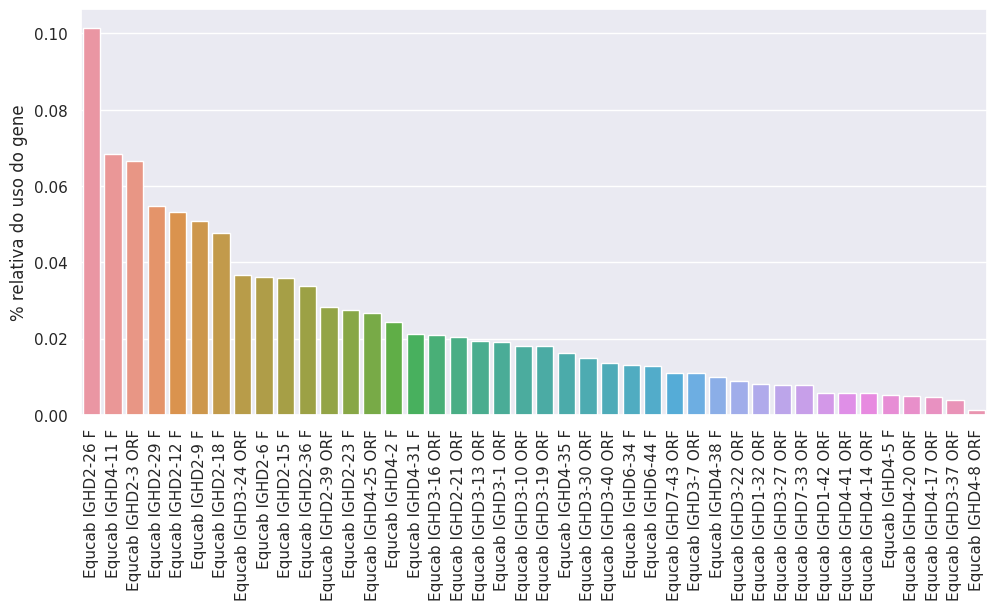

In [7]:
sns.set(rc={'figure.figsize':(11.7, 5.27)})

ax = sns.barplot(x=df_genes2['d_genes'].value_counts(normalize=True).index, y=df_genes2['d_genes'].value_counts(normalize=True))
ax.set(xlabel='', ylabel='% relativa do uso do gene')

plt.xticks(rotation=90)
plt.show()

In [8]:
df_genes2['j_genes'].value_counts(normalize=True)

j_genes
Equcab IGHJ6-1 F                       0.473332
Equcab IGHJ4 F                         0.252959
Equcab IGHJ6-3 F                       0.081860
Equcab IGHJ3 F                         0.079212
Equcab IGHJ6-2 F                       0.051098
Equcab IGHJ5 F                         0.050214
Equcab IGHJ1 ORF                       0.006173
Equcab IGHJ2 ORF                       0.005104
Equcab IGKJ2 F                         0.000023
less than 6 nucleotides are aligned    0.000013
Equcab IGKJ4 F                         0.000009
Equcab IGKJ5 P                         0.000001
Equcab IGKJ1 F                         0.000001
Equcab IGKJ3 F                         0.000001
Name: proportion, dtype: float64

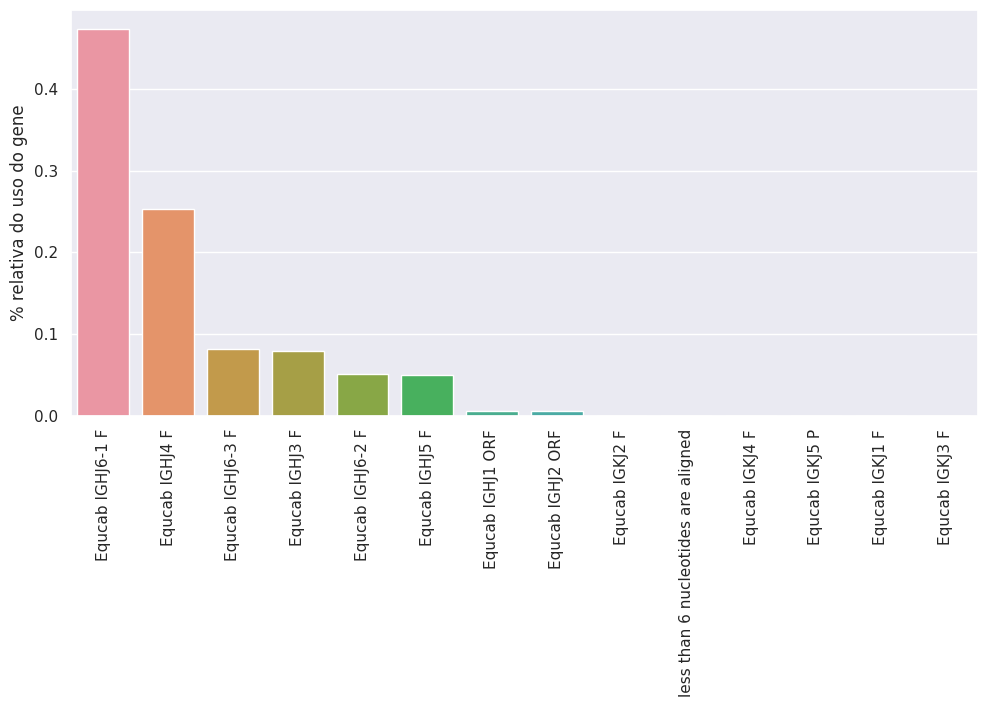

In [9]:
sns.set(rc={'figure.figsize':(11.7, 5.27)})

ax = sns.barplot(
    x=df_genes2['j_genes'].value_counts(normalize=True).index,
    y=df_genes2['j_genes'].value_counts(normalize=True)
)
ax.set(xlabel='', ylabel='% relativa do uso do gene')
plt.xticks(rotation=90)
plt.show()

## Geração de uma imagem única unindo os gráficos acima

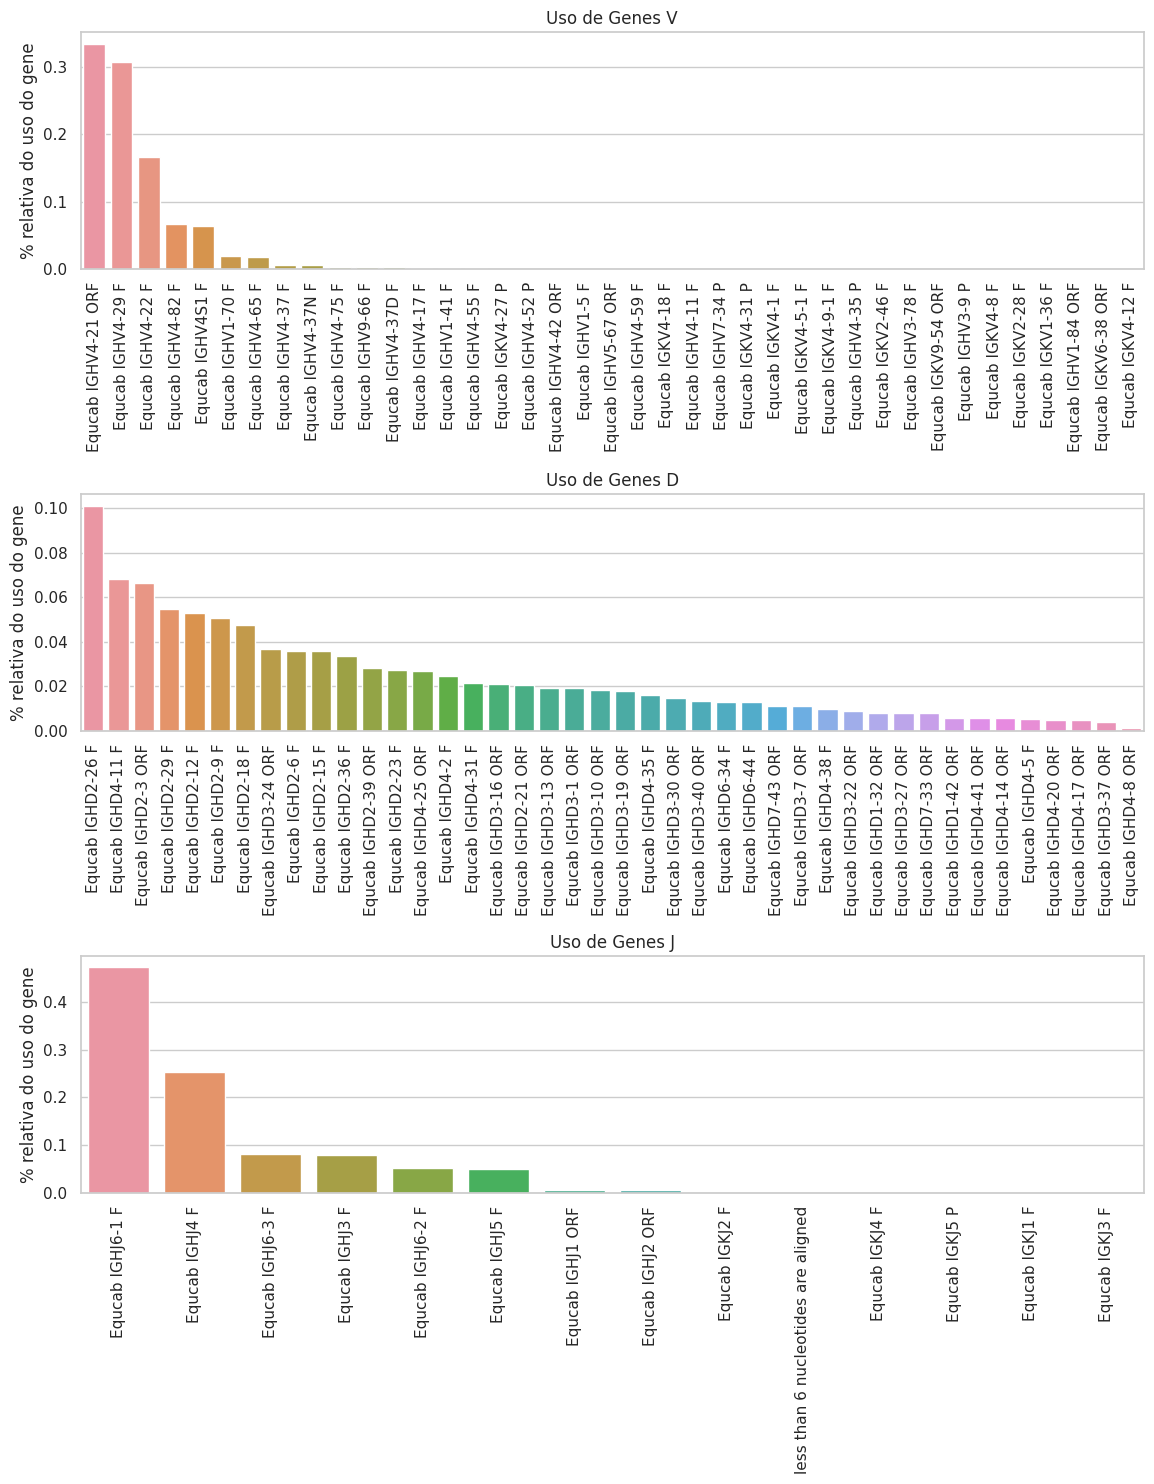

In [83]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(11.7, 15))  # 3 linhas, 1 coluna

# Função para criar gráficos de barras
def plot_bar(ax, column, title):
    counts = column.value_counts(normalize=True)
    sns.barplot(x=counts.index, y=counts, ax=ax)
    ax.set(xlabel='', ylabel='% relativa do uso do gene', title=title)
    ax.tick_params(axis='x', rotation=90)

# Plotar gráficos para cada coluna
plot_bar(axes[0], df_genes2['v_genes'], 'Uso de Genes V')
plot_bar(axes[1], df_genes2['d_genes'], 'Uso de Genes D')
plot_bar(axes[2], df_genes2['j_genes'], 'Uso de Genes J')

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig(f'images/{seq_mnt}-graficos_genes.png', dpi=72)

# Exibir a figura
plt.show()

# Análise de germline

Para essa parte de nossa análise, utilizaremos o change-o, também parte do pipeline do Immcantation.

Começaremos por adicionar o output do HighV-QUEST, que precisa dos dados processados e é recomendado incluir o fasta enviado para o IMGT para corrigir mudanças realizadas pelo HighV-QUEST. Como a anotação feita pelo IMGT contém erros, precisamos antes corrigí-los

In [10]:
os.system('cp '
    "./" + vquest_dir + "/2_IMGT-gapped-nt-sequences.txt " +
    "./" + outdir + "/pipeline/2_IMGT-gapped-nt-sequences.txt"
)

0

In [11]:
gapped_nt = pd.read_table(vquest_dir + "/2_IMGT-gapped-nt-sequences.txt", low_memory=False)

In [12]:
gapped_nt

,Sequence number,Sequence ID,V-DOMAIN Functionality,V-GENE and allele,J-GENE and allele,D-GENE and allele,V-D-J-REGION,V-J-REGION,V-REGION,FR1-IMGT,CDR1-IMGT,FR2-IMGT,CDR2-IMGT,FR3-IMGT,CDR3-IMGT,JUNCTION,J-REGION,FR4-IMGT
0,1,M02832:47:000000000-K3JFG:1:1101:13286:2207|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ4*01 F,Equcab IGHD2-29*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,NaN,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,gctttctctttg............agcagttacggt,gtaaactgggtccgccaggctccaggaaaagggctggaatttgttg...,atcactgatagt.........ggaggtaaa,ttctacaatccagccctgaag...tcccgagccagcatcaccaagg...,gcaggaggtggtagtatttgggggtactattatgattat,tgtgcaggaggtggtagtatttgggggtactattatgattattgg,tattggggccagggcatcctggtcaccgtctcctcag,tggggccagggcatcctggtcaccgtctcctcag
1,2,M02832:47:000000000-K3JFG:1:1101:13494:2227|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ4*01 F,Equcab IGHD2-6*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,NaN,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggattatctttg............agcagtaatagc,gtaggctgggtccgccaggctccaggaaaagggctgcaatatgttg...,acactcaaaagt.........ggcggtgta,gtgtacaacccagccctgaag...tcccgagccagcatcaccaagg...,gtaggagacatggtaacttcactaggagttgcggactttgtctac,tgtgtaggagacatggtaacttcactaggagttgcggactttgtct...,tttgtctactggggccagggcaccctggtcaccgtctcctcag,tggggccagggcaccctggtcaccgtctcctcag
2,3,M02832:47:000000000-K3JFG:1:1101:9844:2245|SEQORI,unproductive,Equcab IGHV4-22*01 F,Equcab IGHJ4*01 F,Equcab IGHD4-2*01 F,caggtgcagctgaaggagacaggagct...gggcaggtgaagccct...,NaN,caggtgcagctgaaggagacaggagct...gggcaggtgaagccct...,caggtgcagctgaaggagacaggagct...gggcaggtgaagccct...,actttctcagtg............agccgttacgtt,gaaaactgggtccgccaggctccaggaaaagg.................,..............................,..........tggtccgccag...gctccaggaa........aagg...,gggaatggcgacggtatgtccacaaggataatagggggtctac,tgtgggaatggcgacggtatgtccacaaggataatagggggtctactgg,ctactggcgccagggtatcctggtcatcgtgtcctcag,tggcgccagggtatcctggtcatcgtgtcctcag
3,4,M02832:47:000000000-K3JFG:1:1101:21814:2212|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ6-1*01 F,Equcab IGHD4-11*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,NaN,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggattctcttgg............agcagagacggt,gtaggctgggtccgccaggctccaggaaaagggctggaatttgttg...,atagatagtagt.........gaaagtgca,cactacaatccagccctgaag...tcccgagccagcatcaccaagg...,acaggaggatcccccgacaataactggggttatgtcatttatggtg...,tgtacaggaggatcccccgacaataactggggttatgtcatttatg...,tactggggccagggcatcctggtcaccgtctcctcag,tggggccagggcatcctggtcaccgtctcctcag
4,5,M02832:47:000000000-K3JFG:1:1101:19851:2230|SEQOR,productive,"Equcab IGHV4-22*01 F, or Equcab IGHV4-29*02 F",Equcab IGHJ6-1*01 F,Equcab IGHD2-18*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,NaN,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggtttctcgttg............agtgattacgct,gtagactgggtccgccaggctccaggaaaaggactggaaggagttg...,atcgatggtgtt.........ggaagtgaa,gactacaatccggccctgaag...tcccgagccagcatcaccacgg...,gcgagatgggggtacgaacgcagtgccggtagttattatgacggca...,tgtgcgagatgggggtacgaacgcagtgccggtagttattatgacg...,tactggggccagggcatcccggtcatcgtctcctccg,tggggccagggcatcccggtcatcgtctcctccg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904616,904617,M02832:47:000000000-K3JFG:1:2119:19699:25284|SEQO,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ6-1*01 F,Equcab IGHD3-10*02 ORF,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,NaN,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggattccctttg............agtgactacggt,gtaatctgggtccgccaggctccaggaaaaggactggaatttgttg...,atgtctcctacg.........ggaagtgtc,aaatacaatcaatccctgaag...tcccgagccagcatcaccaggg...,gcaggcggtagtaagtggtattacacttttgcgtacgaagattatg...,tgtgcaggcggtagtaagtggtattacacttttgcgtacgaagatt...,actggggcgagggcatcc

In [13]:
# print(gapped_nt['V-REGION'][3][:246]+gapped_nt['V-REGION'][3][249:])
gapped_nt["V-REGION"] = gapped_nt["V-REGION"].fillna('').apply(
    lambda w: w[:246] + w[249:] if w[246:249] == '...' else w
)

In [14]:
# print(gapped_nt['V-D-J-REGION'][3][:246]+gapped_nt['V-D-J-REGION'][3][249:])
gapped_nt["V-D-J-REGION"] = gapped_nt["V-D-J-REGION"].fillna('').apply(
    lambda w: w[:246] + w[249:] if w[246:249] == '...' else w
)

In [15]:
# print(gapped_nt['FR3-IMGT'][3][:51]+gapped_nt['FR3-IMGT'][3][54:])
gapped_nt["FR3-IMGT"] = gapped_nt["FR3-IMGT"].fillna('').apply(
    lambda w: w[:51] + w[54:] if w[51:54] == '...' else w
)
# print(gapped_nt['FR3-IMGT'][3])

In [16]:
gapped_nt.to_csv(vquest_dir + "/2_IMGT-gapped-nt-sequences.txt", sep="\t")

In [17]:
gapped_nt = pd.read_table(outdir + "/pipeline/2_IMGT-gapped-nt-sequences.txt", low_memory=False)

In [19]:
gapped_nt = gapped_nt.fillna('')

only_gapped = gapped_nt[gapped_nt['V-REGION'].str[246:249] == '...']

In [20]:
only_gapped

,Sequence number,Sequence ID,V-DOMAIN Functionality,V-GENE and allele,J-GENE and allele,D-GENE and allele,V-D-J-REGION,V-J-REGION,V-REGION,FR1-IMGT,CDR1-IMGT,FR2-IMGT,CDR2-IMGT,FR3-IMGT,CDR3-IMGT,JUNCTION,J-REGION,FR4-IMGT
0,1,M02832:47:000000000-K3JFG:1:1101:13286:2207|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ4*01 F,Equcab IGHD2-29*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,gctttctctttg............agcagttacggt,gtaaactgggtccgccaggctccaggaaaagggctggaatttgttg...,atcactgatagt.........ggaggtaaa,ttctacaatccagccctgaag...tcccgagccagcatcaccaagg...,gcaggaggtggtagtatttgggggtactattatgattat,tgtgcaggaggtggtagtatttgggggtactattatgattattgg,tattggggccagggcatcctggtcaccgtctcctcag,tggggccagggcatcctggtcaccgtctcctcag
1,2,M02832:47:000000000-K3JFG:1:1101:13494:2227|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ4*01 F,Equcab IGHD2-6*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggattatctttg............agcagtaatagc,gtaggctgggtccgccaggctccaggaaaagggctgcaatatgttg...,acactcaaaagt.........ggcggtgta,gtgtacaacccagccctgaag...tcccgagccagcatcaccaagg...,gtaggagacatggtaacttcactaggagttgcggactttgtctac,tgtgtaggagacatggtaacttcactaggagttgcggactttgtct...,tttgtctactggggccagggcaccctggtcaccgtctcctcag,tggggccagggcaccctggtcaccgtctcctcag
2,3,M02832:47:000000000-K3JFG:1:1101:9844:2245|SEQORI,unproductive,Equcab IGHV4-22*01 F,Equcab IGHJ4*01 F,Equcab IGHD4-2*01 F,caggtgcagctgaaggagacaggagct...gggcaggtgaagccct...,,caggtgcagctgaaggagacaggagct...gggcaggtgaagccct...,caggtgcagctgaaggagacaggagct...gggcaggtgaagccct...,actttctcagtg............agccgttacgtt,gaaaactgggtccgccaggctccaggaaaagg.................,..............................,..........tggtccgccag...gctccaggaa........aagg...,gggaatggcgacggtatgtccacaaggataatagggggtctac,tgtgggaatggcgacggtatgtccacaaggataatagggggtctactgg,ctactggcgccagggtatcctggtcatcgtgtcctcag,tggcgccagggtatcctggtcatcgtgtcctcag
3,4,M02832:47:000000000-K3JFG:1:1101:21814:2212|SEQOR,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ6-1*01 F,Equcab IGHD4-11*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggattctcttgg............agcagagacggt,gtaggctgggtccgccaggctccaggaaaagggctggaatttgttg...,atagatagtagt.........gaaagtgca,cactacaatccagccctgaag...tcccgagccagcatcaccaagg...,acaggaggatcccccgacaataactggggttatgtcatttatggtg...,tgtacaggaggatcccccgacaataactggggttatgtcatttatg...,tactggggccagggcatcctggtcaccgtctcctcag,tggggccagggcatcctggtcaccgtctcctcag
4,5,M02832:47:000000000-K3JFG:1:1101:19851:2230|SEQOR,productive,"Equcab IGHV4-22*01 F, or Equcab IGHV4-29*02 F",Equcab IGHJ6-1*01 F,Equcab IGHD2-18*01 F,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggtttctcgttg............agtgattacgct,gtagactgggtccgccaggctccaggaaaaggactggaaggagttg...,atcgatggtgtt.........ggaagtgaa,gactacaatccggccctgaag...tcccgagccagcatcaccacgg...,gcgagatgggggtacgaacgcagtgccggtagttattatgacggca...,tgtgcgagatgggggtacgaacgcagtgccggtagttattatgacg...,tactggggccagggcatcccggtcatcgtctcctccg,tggggccagggcatcccggtcatcgtctcctccg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904616,904617,M02832:47:000000000-K3JFG:1:2119:19699:25284|SEQO,productive,Equcab IGHV4-21*01 ORF,Equcab IGHJ6-1*01 F,Equcab IGHD3-10*02 ORF,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,caggtgcagctgaaggagtcaggacct...ggcctggtgaagccct...,ggattccctttg............agtgactacggt,gtaatctgggtccgccaggctccaggaaaaggactggaatttgttg...,atgtctcctacg.........ggaagtgtc,aaatacaatcaatccctgaag...tcccgagccagcatcaccaggg...,gcaggcggtagtaagtggtattacacttttgcgtacgaagattatg...,tgtgcaggcggtagtaagtggtattacacttttgcgtacgaagatt...,actggggcgagggcatcctggtcatcgtgtcctcgg

In [21]:
!MakeDb.py imgt -i {vquest_dir} -r rawData/germlineRefGeneDB/equus_caballus_gap.fasta \
-s "{outdir}/presto/{seq_mnt}_q{min_quality}-primer-RV_collapse-unique.fastq" --outdir {outdir}/presto\
--outname changeo-db --extended --log "{outdir}/presto/logs/makedb.txt"

       START> MakeDb
     COMMAND> imgt
ALIGNER_FILE> analysis/840_I_F/highv-quest
    SEQ_FILE> 840_I_F_q30-primer-RV_collapse-unique.fastq
     ASIS_ID> False
     PARTIAL> False
    EXTENDED> True

PROGRESS> 11:26:48 |Done                | 0.3 min

PROGRESS> 11:26:48 |                    |   0% (      0) 0.0 minWARNING> Sequence annotation format not recognized. Sequence headers will not be parsed.
PROGRESS> 11:32:01 |####################| 100% (904,621) 5.2 min

OUTPUT> changeo-db_db-pass.tsv
  PASS> 793783
  FAIL> 110838
   END> MakeDb



In [22]:
change_o = pd.read_table(outdir + '/presto/changeo-db_db-pass.tsv')
change_o

/tmp/ipykernel_11706/1438280249.py:1: DtypeWarning: Columns (51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  change_o = pd.read_table(outdir + '/presto/changeo-db_db-pass.tsv')


,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,n2_length,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,d_frame,seqorient,cprimer,vprimer
0,M02832:47:000000000-K3JFG:1:1101:13286:2207,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD2-29*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGAGGTGGTAGTATTTGGGGGTACTATTATGATTATTGG,...,8,0,0,0,0,1.0,3.0,"F,RC",hoHV2_4f,hoHV2_4f
1,M02832:47:000000000-K3JFG:1:1101:13494:2227|SEQOR,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD2-6*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGTAGGAGACATGGTAACTTCACTAGGAGTTGCGGACTTTGTCT...,...,4,0,0,0,0,NaN,1.0,NaN,NaN,NaN
2,M02832:47:000000000-K3JFG:1:1101:9844:2245|SEQORI,GAGTCCTGTCCCAGGTGCAGCTGAAGGAGACAGGAGCTGGGCAGGT...,T,F,Equcab IGHV4-22*01 F,Equcab IGHD4-2*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGACAGGAGCT...GGGCAGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGGGAATGGCGACGGTATGTCCACAAGGATAATAGGGGGTCTACTGG,...,23,0,0,0,0,NaN,3.0,NaN,NaN,NaN
3,M02832:47:000000000-K3JFG:1:1101:21814:2212|SE...,GAGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD4-11*01 F,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGATCCCCCGACAATAACTGGGGTTATGTCATTTATG...,...,17,0,1,0,0,NaN,2.0,NaN,NaN,NaN
4,M02832:47:000000000-K3JFG:1:1101:19851:2230|SE...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-22*01 F,Equcab IGHV4-29*02 F",Equcab IGHD2-18*01 F,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCGAGATGGGGGTACGAACGCAGTGCCGGTAGTTATTATGACG...,...,11,1,0,0,0,NaN,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793778,M02832:47:000000000-K3JFG:1:2119:19699:25284|SEQO,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD3-10*02 ORF,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGCGGTAGTAAGTGGTATTACACTTTTGCGTACGAAGATT...,...,20,0,0,0,0,NaN,2.0,NaN,NaN,NaN
793779,M02832:47:000000000-K3JFG:1:2119:11599:25211|S...,GAGTCCTCTCCCAGGTGCAGCTGAAGGAGTCGGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD2-18*01 F,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCGGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGATATGGTCTCTATACTGGTAGTTACTATCCTCTTCGTA...,...,7,0,1,0,0,NaN,3.0,NaN,NaN,NaN
793780,M02832:47:000000000-K3JFG:1:2119:13246:25292|SEQO,GTGTCCTCTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-29*01 F,Equcab IGHD7-43*01 ORF,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGTAGGACAGTTACATGTCAGTGTTGGTCAGACCTACTGG,...,5,0,0,0,0,NaN,1.0,NaN,NaN,NaN
793781,M02832:47:000000000-K3JFG:1:2119:16091:25273|S...,GTGTCCTGTCCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGG...,F,T,Equcab IGHV4-21*01 ORF,Equcab IGHD3-24*02 ORF,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGAGGCCGCTTCTTCGGAGGGTGGACTAGCGATCCGGATG...,...,5,2,0,0,0,NaN,3.0,NaN,NaN,NaN


In [23]:
change_o[change_o['d_call'].isna()]

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,n2_length,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,d_frame,seqorient,cprimer,vprimer
34,M02832:47:000000000-K3JFG:1:1101:18310:2243|SE...,GAGTCCTGTCCCAGGTGCAACTGAAGGAGTCAGGACCTGGCCTGGT...,F,T,Equcab IGHV4-21*01 ORF,NaN,Equcab IGHJ4*01 F,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTAAAGGCTTTGGCTACTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
109,M02832:47:000000000-K3JFG:1:1101:15758:2562|SE...,GTGTCCTGTCCCAGGTGCAACTGAAGGAGTCGGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,NaN,Equcab IGHJ4*01 F,CAGGTGCAACTGAAGGAGTCGGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTAAAGGCTTTGGCTACTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
111,M02832:47:000000000-K3JFG:1:1101:8915:2395|SEQ...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-22*01 F,NaN,Equcab IGHJ5*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCGAGACGGTGGGACTACTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
147,M02832:47:000000000-K3JFG:1:1101:15756:2402|SE...,GTGTCTCCTCCGAGGGTCAGCTAAAGGAGTCAGGACCTGACCTACT...,F,T,Equcab IGHV4-22*01 F,NaN,Equcab IGHJ4*01 F,GAGGGTCAGCTAAAGGAGTCAGGACCT...GACCTACTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTCAGGCTGGATATTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
148,M02832:47:000000000-K3JFG:1:1101:24822:2691|SEQOR,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCGGGACCTGATCTGGT...,T,T,Equcab IGHV4-22*01 F,NaN,Equcab IGHJ5*01 F,CAGGTGCAGCTGAAGGAGTCGGGACCT...GATCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAAGATTGGATTACTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793582,M02832:47:000000000-K3JFG:1:2119:13159:24919|SEQO,GTGTCCTGTCCCAGGTGCAACTGAAGGAGTCGGGACCTGATCTGGT...,T,T,Equcab IGHV4-22*01 F,NaN,Equcab IGHJ5*01 F,CAGGTGCAACTGAAGGAGTCGGGACCT...GATCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAAGATTGGATTACTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
793667,M02832:47:000000000-K3JFG:1:2119:17942:25067|S...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,NaN,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTAAAGGCTTTGGCTACTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
793675,M02832:47:000000000-K3JFG:1:2119:22584:25077|S...,GAGTCCTGTCCCAGGTGAAGCTGAAGGAGTCGGGACCTGATCTGGT...,T,T,Equcab IGHV4-22*01 F,NaN,Equcab IGHJ5*01 F,CAGGTGAAGCTGAAGGAGTCGGGACCT...GATCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAAGATTGGATTACTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
793707,M02832:47:000000000-K3JFG:1:2119:16201:25234|S...,GTGTCCTGTCCCAGGTGAAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4S1*01 F,NaN,Equcab IGHJ6-1*01 F,CAGGTGAAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCGGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGAACAAAGTATTGG,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [24]:
change_o[change_o['productive']=='T'] 

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,n2_length,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,d_frame,seqorient,cprimer,vprimer
0,M02832:47:000000000-K3JFG:1:1101:13286:2207,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD2-29*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGAGGTGGTAGTATTTGGGGGTACTATTATGATTATTGG,...,8,0,0,0,0,1.0,3.0,"F,RC",hoHV2_4f,hoHV2_4f
1,M02832:47:000000000-K3JFG:1:1101:13494:2227|SEQOR,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD2-6*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGTAGGAGACATGGTAACTTCACTAGGAGTTGCGGACTTTGTCT...,...,4,0,0,0,0,NaN,1.0,NaN,NaN,NaN
3,M02832:47:000000000-K3JFG:1:1101:21814:2212|SE...,GAGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD4-11*01 F,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGATCCCCCGACAATAACTGGGGTTATGTCATTTATG...,...,17,0,1,0,0,NaN,2.0,NaN,NaN,NaN
4,M02832:47:000000000-K3JFG:1:1101:19851:2230|SE...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-22*01 F,Equcab IGHV4-29*02 F",Equcab IGHD2-18*01 F,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCGAGATGGGGGTACGAACGCAGTGCCGGTAGTTATTATGACG...,...,11,1,0,0,0,NaN,3.0,NaN,NaN,NaN
5,M02832:47:000000000-K3JFG:1:1101:9537:2290|SEQ...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-29*01 F,Equcab IGHD2-18*01 F,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGTAGGAGAGTCTGGTAACGGTGCAGGTCACGGTTGGGGTATAA...,...,9,0,0,0,0,NaN,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793778,M02832:47:000000000-K3JFG:1:2119:19699:25284|SEQO,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD3-10*02 ORF,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGCGGTAGTAAGTGGTATTACACTTTTGCGTACGAAGATT...,...,20,0,0,0,0,NaN,2.0,NaN,NaN,NaN
793779,M02832:47:000000000-K3JFG:1:2119:11599:25211|S...,GAGTCCTCTCCCAGGTGCAGCTGAAGGAGTCGGGACCTGGCCTGGT...,T,T,Equcab IGHV4-21*01 ORF,Equcab IGHD2-18*01 F,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCGGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGATATGGTCTCTATACTGGTAGTTACTATCCTCTTCGTA...,...,7,0,1,0,0,NaN,3.0,NaN,NaN,NaN
793780,M02832:47:000000000-K3JFG:1:2119:13246:25292|SEQO,GTGTCCTCTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,Equcab IGHV4-29*01 F,Equcab IGHD7-43*01 ORF,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGTAGGACAGTTACATGTCAGTGTTGGTCAGACCTACTGG,...,5,0,0,0,0,NaN,1.0,NaN,NaN,NaN
793781,M02832:47:000000000-K3JFG:1:2119:16091:25273|S...,GTGTCCTGTCCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGG...,F,T,Equcab IGHV4-21*01 ORF,Equcab IGHD3-24*02 ORF,Equcab IGHJ6-1*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGAGGCCGCTTCTTCGGAGGGTGGACTAGCGATCCGGATG...,...,5,2,0,0,0,NaN,3.0,NaN,NaN,NaN


In [25]:
change_o.describe()

,v_cigar,d_cigar,j_cigar,junction_length,np1_length,np2_length,v_sequence_start,v_sequence_end,v_germline_start,v_germline_end,...,j_score,j_identity,n1_length,n2_length,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,d_frame
count,0.0,0.0,0.0,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,793783.0,793783.000000,...,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,1.0,781955.000000
mean,NaN,NaN,NaN,50.079646,8.864588,9.271565,11.896972,299.200759,1.0,316.266987,...,187.823100,0.845966,8.620384,9.202137,0.194483,0.049721,0.047160,0.022268,1.0,2.415245
std,NaN,NaN,NaN,13.509641,7.504338,8.240001,1.109791,7.970424,0.0,2.831353,...,28.554476,0.060505,7.538659,8.253303,0.549780,0.275050,0.272801,0.211329,NaN,0.732026
min,NaN,NaN,NaN,7.000000,0.000000,0.000000,1.000000,55.000000,1.0,310.000000,...,26.000000,0.604200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000
25%,NaN,NaN,NaN,42.000000,3.000000,3.000000,12.000000,298.000000,1.0,314.000000,...,171.000000,0.796300,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.000000
50%,NaN,NaN,NaN,51.000000,7.000000,7.000000,12.000000,300.000000,1.0,317.000000,...,189.000000,0.851900,7.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.000000
75%,NaN,NaN,NaN,60.000000,13.000000,14.000000,12.000000,303.000000,1.0,319.000000,...,207.000000,0.888900,13.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.000000
max,NaN,NaN,NaN,138.000000,78.000000,70.000000,71.000000,355.000000,1.0,336.000000,...,276.000000,1.000000,78.000000,70.000000,6.000000,5.000000,8.000000,3.000000,1.0,3.000000


In [26]:
change_o.columns

Index(['sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call',
       'j_call', 'sequence_alignment', 'germline_alignment', 'junction',
       'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon',
       'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length',
       'v_sequence_start', 'v_sequence_end', 'v_germline_start',
       'v_germline_end', 'd_sequence_start', 'd_sequence_end',
       'd_germline_start', 'd_germline_end', 'j_sequence_start',
       'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score',
       'v_identity', 'j_score', 'j_identity', 'fwr1', 'fwr2', 'fwr3', 'fwr4',
       'cdr1', 'cdr2', 'cdr3', 'n1_length', 'n2_length', 'p3v_length',
       'p5d_length', 'p3d_length', 'p5j_length', 'duplicate_count', 'd_frame',
       'seqorient', 'cprimer', 'vprimer'],
      dtype='object')

In [27]:
change_o['duplicate_count'].describe()

count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: duplicate_count, dtype: float64

In [28]:
change_o[change_o['productive'] == 'F']

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,n2_length,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,d_frame,seqorient,cprimer,vprimer
2,M02832:47:000000000-K3JFG:1:1101:9844:2245|SEQORI,GAGTCCTGTCCCAGGTGCAGCTGAAGGAGACAGGAGCTGGGCAGGT...,T,F,Equcab IGHV4-22*01 F,Equcab IGHD4-2*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGACAGGAGCT...GGGCAGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGGGAATGGCGACGGTATGTCCACAAGGATAATAGGGGGTCTACTGG,...,23,0,0,0,0,NaN,3.0,NaN,NaN,NaN
86,M02832:47:000000000-K3JFG:1:1101:18188:2331|SE...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGACAGGAGCTGGGCAGGT...,T,F,Equcab IGHV4-22*01 F,Equcab IGHD4-2*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGACAGGAGCT...GGGCAGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGGGAATGGCGACGGTATGTCCACAAGGATAATAGGGGGTCTACTGG,...,23,0,0,0,0,NaN,3.0,NaN,NaN,NaN
152,M02832:47:000000000-K3JFG:1:1101:24824:2608|SEQOR,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,F,Equcab IGHV4-21*01 ORF,Equcab IGHD2-29*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTAGGAGGCGGTGGTTGGTCCTGGTACGGGGATTTTGGCTACTGG,...,4,0,0,0,0,NaN,3.0,NaN,NaN,NaN
171,M02832:47:000000000-K3JFG:1:1101:21148:2611|SE...,GTGTCCTGTCCCAGGTGAAGCTGAAGGAGTCGGGACCCGGCCTGGT...,T,F,Equcab IGHV4S1*01 F,Equcab IGHD2-6*01 F,Equcab IGHJ6-1*01 F,CAGGTGAAGCTGAAGGAGTCGGGACCC...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCGGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAGGATGCGGCGGATGGTAGATATGGTTACTGAGGTGGGAGT...,...,7,1,2,0,0,NaN,3.0,NaN,NaN,NaN
185,M02832:47:000000000-K3JFG:1:1101:12018:2405|SE...,GTGTCCTGTTCCAGGTGTAGCTGAGGGAGTCAGGACCTGGCCTGGT...,F,F,"Equcab IGHV4-22*01 F,Equcab IGHV4-29*02 F",Equcab IGHD2-18*01 F,Equcab IGHJ6-1*01 F,CAGGTGTAGCTGAGGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGTGCAGTTAGCATTCTGGAATTATGTTGGTGGCTACGTTTGG,...,3,0,0,0,0,NaN,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793588,M02832:47:000000000-K3JFG:1:2119:22078:24891|S...,GTGTCCTCTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,F,Equcab IGHV4-29*01 F,Equcab IGHD4-25*01 ORF,"Equcab IGHJ6-3*01 F,Equcab IGHJ6-4*01 ORF",CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTGCAAGAGGCGGCAACTCTGATTACTACCAGTTCGATTTTTTTA...,...,19,0,0,0,0,NaN,3.0,NaN,NaN,NaN
793641,M02832:47:000000000-K3JFG:1:2119:18199:24994|SEQO,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,F,Equcab IGHV4-29*01 F,Equcab IGHD3-27*01 ORF,Equcab IGHJ3*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGATCCTTCCGCCCTCCGAGGGTACGAGGATCTCTGG,...,4,0,0,0,0,NaN,2.0,NaN,NaN,NaN
793691,M02832:47:000000000-K3JFG:1:2119:12390:25123|S...,GAGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,F,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-16*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATTTTGAAGGCTGG,...,7,0,0,0,0,NaN,2.0,NaN,NaN,NaN
793714,M02832:47:000000000-K3JFG:1:2119:20320:25030|S...,GTGTCTCCTCCGAGGTCCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,F,F,Equcab IGHV4-29*01 F,Equcab IGHD2-6*01 F,Equcab IGHJ4*01 F,GAGGTCCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTTCGAGAAAAATATGGTTACTATAGTAGGATTGGCACGCCTCGG...,...,17,0,2,0,0,NaN,2.0,NaN,NaN,NaN


# Frequência de combinação V(D)J 

In [29]:
count_vdj_use = change_o.groupby(['v_call', 'd_call', 'j_call']).size().to_frame(name = 'size').reset_index()
count_vdj_use.sort_values(by=['size'], ascending=False)

,v_call,d_call,j_call,size
434,Equcab IGHV4-21*01 ORF,Equcab IGHD2-26*01 F,Equcab IGHJ6-1*01 F,11641
4025,Equcab IGHV4-29*01 F,Equcab IGHD2-26*01 F,Equcab IGHJ6-1*01 F,10206
888,Equcab IGHV4-21*01 ORF,Equcab IGHD4-11*01 F,Equcab IGHJ6-1*01 F,9773
4385,Equcab IGHV4-29*01 F,Equcab IGHD4-11*01 F,Equcab IGHJ6-1*01 F,7803
486,Equcab IGHV4-21*01 ORF,Equcab IGHD2-3*01 ORF,Equcab IGHJ6-1*01 F,7561
...,...,...,...,...
4339,Equcab IGHV4-29*01 F,Equcab IGHD3-40*01 ORF,Equcab IGHJ3*01 F,1
4340,Equcab IGHV4-29*01 F,Equcab IGHD3-40*01 ORF,Equcab IGHJ3*01 F,1
4349,Equcab IGHV4-29*01 F,Equcab IGHD3-40*01 ORF,Equcab IGHJ6-2*01 F,1
4352,Equcab IGHV4-29*01 F,Equcab IGHD3-7*01 ORF,Equcab IGHJ3*01 F,1


In [30]:
count_vdj_use2 = change_o[['v_call', 'd_call', 'j_call']].dropna().apply('|'.join, axis=1)
count_vdj_use2.value_counts(normalize=False)

Equcab IGHV4-21*01 ORF|Equcab IGHD2-26*01 F|Equcab IGHJ6-1*01 F                                          11641
Equcab IGHV4-29*01 F|Equcab IGHD2-26*01 F|Equcab IGHJ6-1*01 F                                            10206
Equcab IGHV4-21*01 ORF|Equcab IGHD4-11*01 F|Equcab IGHJ6-1*01 F                                           9773
Equcab IGHV4-29*01 F|Equcab IGHD4-11*01 F|Equcab IGHJ6-1*01 F                                             7803
Equcab IGHV4-21*01 ORF|Equcab IGHD2-3*01 ORF|Equcab IGHJ6-1*01 F                                          7561
                                                                                                         ...  
Equcab IGHV4-22*01 F |Equcab IGHD4-35*01 F|Equcab IGHJ3*01 F                                                 1
Equcab IGHV4-29*01 F |Equcab IGHD4-41*01 ORF|Equcab IGHJ6-1*01 F                                             1
Equcab IGHV4-21*01 ORF|Equcab IGHD3-13*01 ORF|Equcab IGHJ3*01 F,Equcab IGHJ6-1*01 F                          1
E

In [31]:
count_vdj_use2.value_counts(normalize=True)

Equcab IGHV4-21*01 ORF|Equcab IGHD2-26*01 F|Equcab IGHJ6-1*01 F                                          0.014887
Equcab IGHV4-29*01 F|Equcab IGHD2-26*01 F|Equcab IGHJ6-1*01 F                                            0.013052
Equcab IGHV4-21*01 ORF|Equcab IGHD4-11*01 F|Equcab IGHJ6-1*01 F                                          0.012498
Equcab IGHV4-29*01 F|Equcab IGHD4-11*01 F|Equcab IGHJ6-1*01 F                                            0.009979
Equcab IGHV4-21*01 ORF|Equcab IGHD2-3*01 ORF|Equcab IGHJ6-1*01 F                                         0.009669
                                                                                                           ...   
Equcab IGHV4-22*01 F |Equcab IGHD4-35*01 F|Equcab IGHJ3*01 F                                             0.000001
Equcab IGHV4-29*01 F |Equcab IGHD4-41*01 ORF|Equcab IGHJ6-1*01 F                                         0.000001
Equcab IGHV4-21*01 ORF|Equcab IGHD3-13*01 ORF|Equcab IGHJ3*01 F,Equcab IGHJ6-1*01 F     

Mostrar quantas recombinações temos

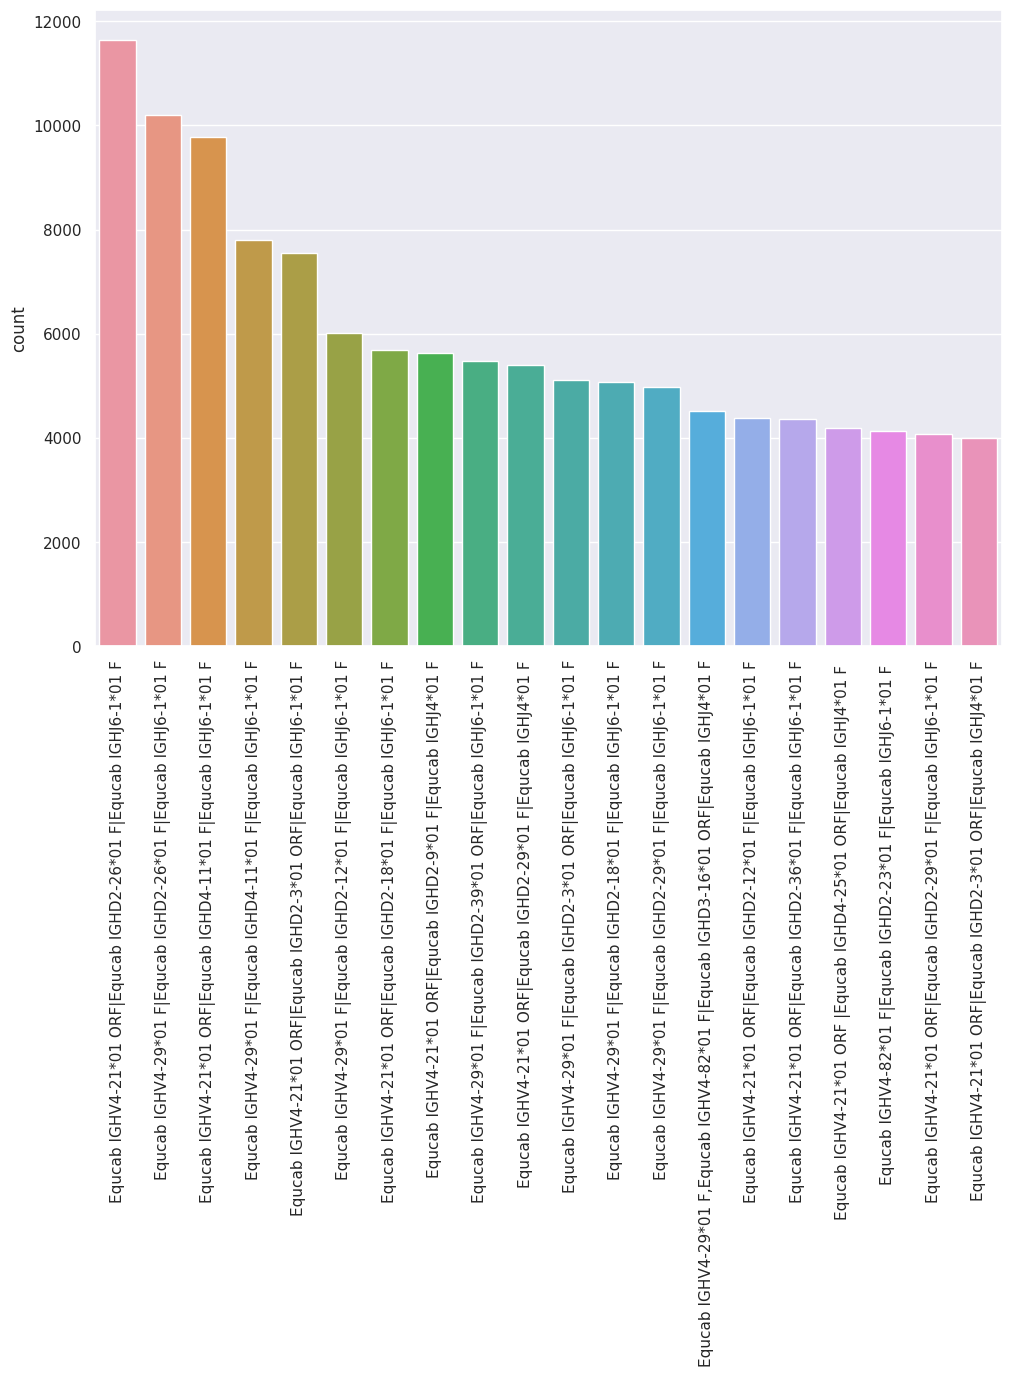

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x=count_vdj_use2.value_counts().head(20).index,
            y=count_vdj_use2.value_counts().head(20))
plt.xticks(rotation=90)
plt.show()

In [84]:
count_vdj_use3 = change_o[['v_call', 'd_call', 'j_call']].dropna()
count_vdj_use3['v_call'] = count_vdj_use3['v_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use3['d_call'] = count_vdj_use3['d_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use3['j_call'] = count_vdj_use3['j_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use3 = count_vdj_use3.apply('|'.join, axis=1)
count_vdj_use3.value_counts(normalize=True)

Equcab IGHV4-21|Equcab IGHD2-26|Equcab IGHJ6-1    0.022446
Equcab IGHV4-29|Equcab IGHD2-26|Equcab IGHJ6-1    0.019427
Equcab IGHV4-21|Equcab IGHD4-11|Equcab IGHJ6-1    0.018048
Equcab IGHV4-29|Equcab IGHD4-11|Equcab IGHJ6-1    0.014933
Equcab IGHV4-21|Equcab IGHD2-3|Equcab IGHJ6-1     0.013411
                                                    ...   
Equcab IGHV4-29|Equcab IGHD2-3|Equcab IGHJ2       0.000001
Equcab IGHV4-82|Equcab IGHD3-7|Equcab IGHJ4       0.000001
Equcab IGHV4-37N|Equcab IGHD2-9|Equcab IGHJ6-2    0.000001
Equcab IGHV4-17|Equcab IGHD3-13|Equcab IGHJ6-2    0.000001
Equcab IGHV4-22|Equcab IGHD3-7|Equcab IGHJ1       0.000001
Name: proportion, Length: 1823, dtype: float64

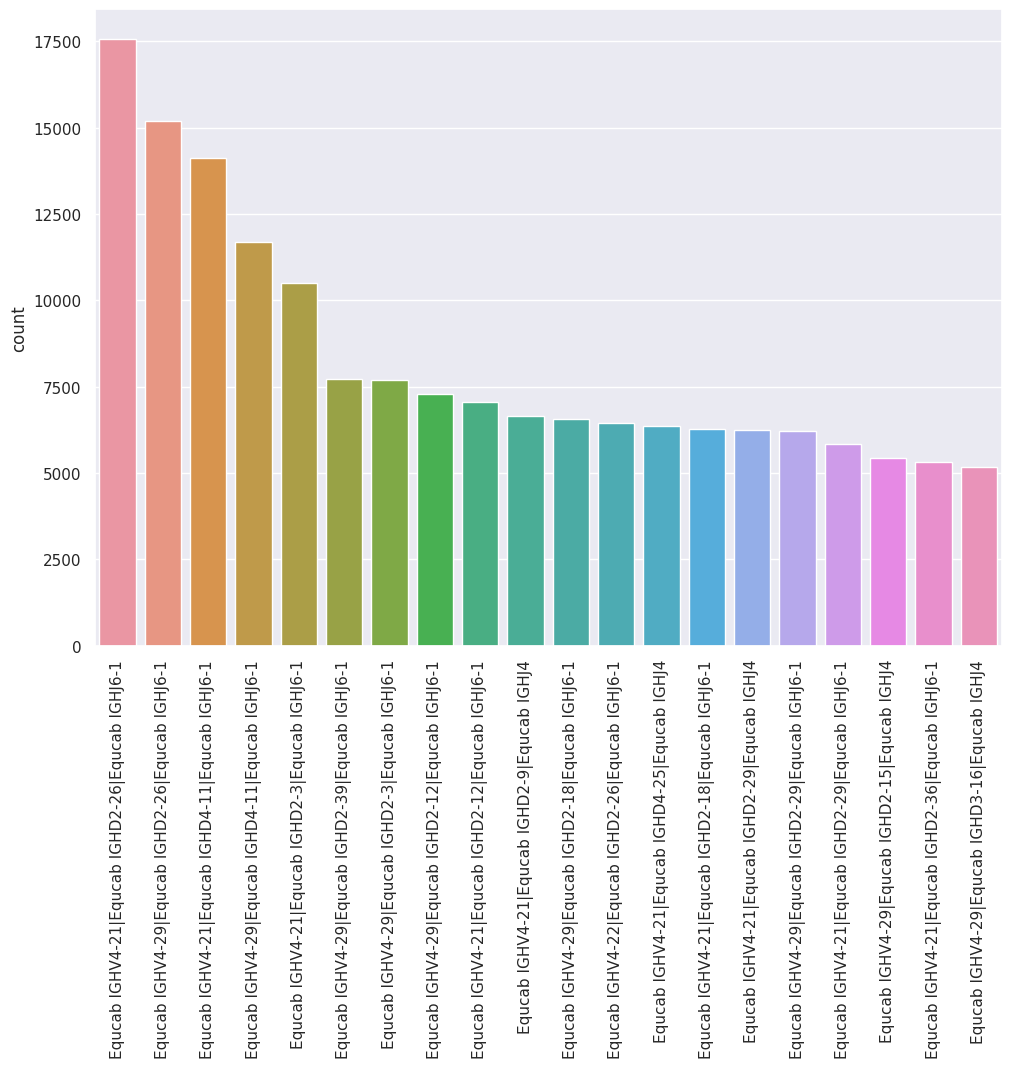

In [85]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x=count_vdj_use3.value_counts().head(20).index,
            y=count_vdj_use3.value_counts().head(20))
plt.xticks(rotation=90)
plt.show()

# Tamanho médio de CDR

In [33]:
cdr3 = change_o.dropna(subset=['v_call', 'd_call', 'j_call']).loc[change_o['productive'] == 'T'][['cdr3', 'sequence_id']].copy()
cdr3['cdr3_len'] = cdr3['cdr3'].str.len()
cdr3.sort_values(by='cdr3_len', ascending=False)

,cdr3,sequence_id,cdr3_len
274520,ACAGGAGGCATCGAGACGGAAGGGGAACAATTGGAGGTGGTCCAGG...,M02832:47:000000000-K3JFG:1:1114:16100:20303|SEQO,96
274480,ACAGGAGGCATCGAGACGGAAGGGGAACAATTGGAGGTGGTCCAGG...,M02832:47:000000000-K3JFG:1:1114:16088:20289|S...,96
249712,GCAGGAGGCGAATTATGGATAGTAGGGGATGACTTTCTTAATACTG...,M02832:47:000000000-K3JFG:1:1113:20050:16658|SEQO,93
273323,GCAGGAGGCGAATTATGGATAGTAGGGGATGACTTTCTTAATACTG...,M02832:47:000000000-K3JFG:1:1114:8964:19041|SEQOR,93
437157,GCAGGAGGCGAATTATGGATAGTAGGGGATGACTTTCTTAATACTG...,M02832:47:000000000-K3JFG:1:2103:9969:16202|SEQOR,93
...,...,...,...
142774,TACGCGCAGAAA,M02832:47:000000000-K3JFG:1:1108:25785:11624|SEQO,12
142752,GTTACGTTATAC,M02832:47:000000000-K3JFG:1:1108:9922:11676|SE...,12
514831,GAATCACTTTAC,M02832:47:000000000-K3JFG:1:2107:22901:11375|SEQO,12
626009,GTTACGTTATAC,M02832:47:000000000-K3JFG:1:2112:21492:16339|SEQO,12


In [34]:
change_o[change_o['cdr3'].str.len() == 166]

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,n2_length,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,d_frame,seqorient,cprimer,vprimer


In [35]:
cdr3.describe()

,cdr3_len
count,758592.000000
mean,44.397344
std,13.085360
min,12.000000
25%,36.000000
50%,45.000000
75%,54.000000
max,96.000000


In [86]:
cdr3['cdr3_len'].divide(3).describe()

count    758592.000000
mean         14.799115
std           4.361787
min           4.000000
25%          12.000000
50%          15.000000
75%          18.000000
max          32.000000
Name: cdr3_len, dtype: float64

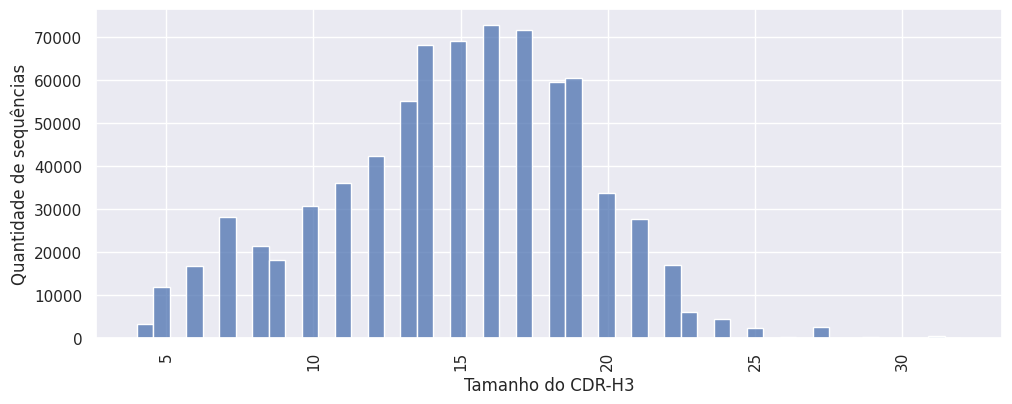

In [36]:
sns.set(rc={'figure.figsize':(11.7,4.27)})

ax = sns.histplot(cdr3['cdr3_len'].divide(3), kde=False, bins=50)
ax.set(xlabel='Tamanho do CDR-H3', ylabel='Quantidade de sequências')

plt.xticks(rotation=90)
plt.show()

<Axes: >

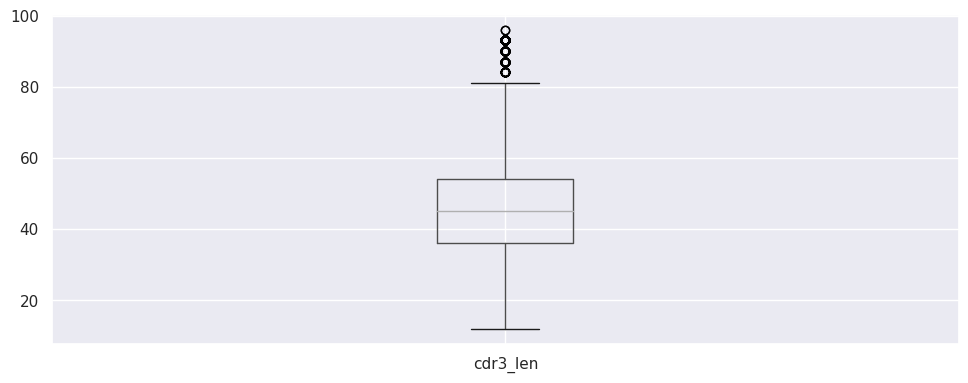

In [37]:
cdr3.boxplot(column=['cdr3_len'], return_type=None)

In [1]:
amino_acids = {
    'TTT': 'F',
    'TTC': 'F',
    'TTA': 'L',
    'TTG': 'L',
    'TCT': 'S',
    'TCC': 'S',
    'TCA': 'S',
    'TCG': 'S',
    'TAT': 'Y',
    'TAC': 'Y',
    'TAA': 'Stop',
    'TAG': 'Stop',
    'TGT': 'C',
    'TGC': 'C',
    'TGA': 'Stop',
    'TGG': 'W',
    'CTT': 'L',
    'CTC': 'L',
    'CTA': 'L',
    'CTG': 'L',
    'CCT': 'P',
    'CCC': 'P',
    'CCA': 'P',
    'CCG': 'P',
    'CAT': 'H',
    'CAC': 'H',
    'CAA': 'Q',
    'CAG': 'Q',
    'CGT': 'R',
    'CGC': 'R',
    'CGA': 'R',
    'CGG': 'R',
    'ATT': 'I',
    'ATC': 'I',
    'ATA': 'I',
    'ATG': 'M',
    'ACT': 'T',
    'ACC': 'T',
    'ACA': 'T',
    'ACG': 'T',
    'AAT': 'N',
    'AAC': 'N',
    'AAA': 'K',
    'AAG': 'K',
    'AGT': 'S',
    'AGC': 'S',
    'AGA': 'R',
    'AGG': 'R',
    'GTT': 'V',
    'GTC': 'V',
    'GTA': 'V',
    'GTG': 'V',
    'GCT': 'A',
    'GCC': 'A',
    'GCA': 'A',
    'GCG': 'A',
    'GAT': 'D',
    'GAC': 'D',
    'GAA': 'E',
    'GAG': 'E',
    'GGT': 'G',
    'GGC': 'G',
    'GGA': 'G',
    'GGG': 'G'
}

In [4]:
amino_acids_list = []
try:
    cdr3
except NameError:
    change_o = pd.read_table(outdir + '/presto/changeo-db_db-pass.tsv')
    cdr3 = change_o.dropna(subset=['v_call', 'd_call', 'j_call']).loc[change_o['productive'] == 'T'][['cdr3', 'sequence_id']].copy()
    cdr3['cdr3_len'] = cdr3['cdr3'].str.len()

for row in cdr3.iloc:
    for aa in re.findall('...', row.cdr3):
        amino_acids_list.append(amino_acids[aa])
amino_acids_list[:50]

/tmp/ipykernel_4155/2515067596.py:5: DtypeWarning: Columns (51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  change_o = pd.read_table(outdir + '/presto/changeo-db_db-pass.tsv')


['A',
 'G',
 'G',
 'G',
 'S',
 'I',
 'W',
 'G',
 'Y',
 'Y',
 'Y',
 'D',
 'Y',
 'V',
 'G',
 'D',
 'M',
 'V',
 'T',
 'S',
 'L',
 'G',
 'V',
 'A',
 'D',
 'F',
 'V',
 'Y',
 'T',
 'G',
 'G',
 'S',
 'P',
 'D',
 'N',
 'N',
 'W',
 'G',
 'Y',
 'V',
 'I',
 'Y',
 'G',
 'E',
 'T',
 'Y',
 'A',
 'R',
 'W',
 'G']

In [5]:
amino_acids_series = pd.Series(amino_acids_list, copy=False)
amino_acids_series.value_counts(normalize=True).head(30)

G    0.177851
Y    0.151693
A    0.086724
D    0.081316
S    0.070675
V    0.055719
T    0.045163
L    0.041507
N    0.041444
F    0.041155
I    0.037521
R    0.036482
W    0.028744
E    0.027667
P    0.022328
H    0.016775
M    0.012487
K    0.012315
Q    0.008885
C    0.003550
Name: proportion, dtype: float64

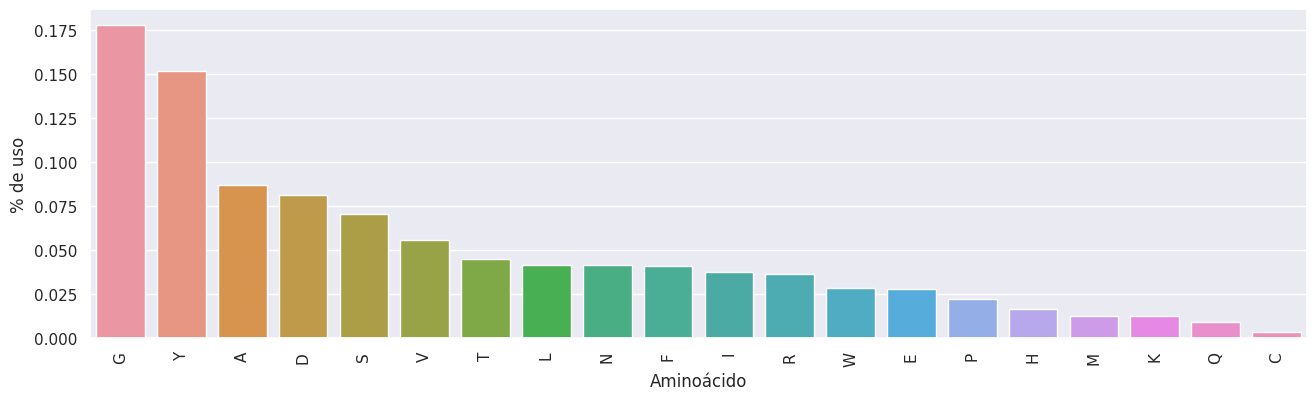

In [7]:
amino_acids_series = pd.Series(amino_acids_list, copy=False)
sns.set(rc={'figure.figsize':(15.7,4.27)})

ax = sns.barplot(x=amino_acids_series.value_counts(normalize=True).head(50).index,
            y=amino_acids_series.value_counts(normalize=True).head(50))
ax.set(xlabel='Aminoácido', ylabel='% de uso')

plt.xticks(rotation=90)
plt.show()

# Clusterizando sequências

Para realizar essa etapa, o pacote shazam, do R, precisou ser usado, e foi utilizado por fora deste notebook. Porém, seguem os comandos realizados na imagem docker do immcantation:

- library(shazam)
- changeo_db <- read.table(file='/data/changeo-db_db-pass.tsv', sep='\t', header= TRUE)
- dist_ham <- distToNearest(changeo_db, sequenceColumn="junction", 
                          vCallColumn="v_call", jCallColumn="j_call",
                          model="ham", normalize="len", nproc=1)
- output <- findThreshold(dist_ham$dist_nearest, method="density")
- threshold <- output@threshold
- threshold

O threshold encontrado foi de 0.1161177

In [ ]:
!DefineClones.py -d "{outdir}/presto/changeo-db_db-pass.tsv" --act set --model ham \
    --norm len --dist 0.1161177

/home/milenebc/milenebc/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
       START> DefineClones
        FILE> changeo-db_db-pass.tsv
   SEQ_FIELD> junction
     V_FIELD> v_call
     J_FIELD> j_call
 MAX_MISSING> 0
GROUP_FIELDS> None
      ACTION> set
        MODE> gene
    DISTANCE> 0.1161177
     LINKAGE> single
       MODEL> ham
        NORM> len
         SYM> avg
       NPROC> 20

PROGRESS> [Grouping sequences] 14:06:24 (793783) 32.2 min

PROGRESS> [Assigning clones] 14:06:24 |                    |   0% (      0) 31.3 min

In [ ]:
clones = pd.read_table(outdir + "/presto/changeo-db_db-pass_clone-pass.tsv")
pd.set_option('display.max_columns', None)
clones.describe()

In [90]:
clones.columns

Index(['sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call',
       'j_call', 'sequence_alignment', 'germline_alignment', 'junction',
       'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon',
       'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length',
       'v_sequence_start', 'v_sequence_end', 'v_germline_start',
       'v_germline_end', 'd_sequence_start', 'd_sequence_end',
       'd_germline_start', 'd_germline_end', 'j_sequence_start',
       'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score',
       'v_identity', 'j_score', 'j_identity', 'fwr1', 'fwr2', 'fwr3', 'fwr4',
       'cdr1', 'cdr2', 'cdr3', 'n1_length', 'n2_length', 'p3v_length',
       'p5d_length', 'p3d_length', 'p5j_length', 'duplicate_count', 'clone_id',
       'd_frame', 'seqorient', 'cprimer', 'vprimer'],
      dtype='object')

In [ ]:
pd.set_option('display.max_columns', None)
clones[clones['clone_id'] == 2326]

In [ ]:
pd.reset_option('max_columns')

In [89]:
clones.describe()

,v_cigar,d_cigar,j_cigar,junction_length,np1_length,np2_length,v_sequence_start,v_sequence_end,v_germline_start,v_germline_end,...,j_identity,n1_length,n2_length,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,clone_id,d_frame
count,0.0,0.0,0.0,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,793783.0,793783.000000,...,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,793783.000000,1.0,793783.00000,781955.000000
mean,NaN,NaN,NaN,50.079646,8.864588,9.271565,11.896972,299.200759,1.0,316.266987,...,0.845966,8.620384,9.202137,0.194483,0.049721,0.047160,0.022268,1.0,6286.15002,2.415245
std,NaN,NaN,NaN,13.509641,7.504338,8.240001,1.109791,7.970424,0.0,2.831353,...,0.060505,7.538659,8.253303,0.549780,0.275050,0.272801,0.211329,NaN,3543.19983,0.732026
min,NaN,NaN,NaN,7.000000,0.000000,0.000000,1.000000,55.000000,1.0,310.000000,...,0.604200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.00000,1.000000
25%,NaN,NaN,NaN,42.000000,3.000000,3.000000,12.000000,298.000000,1.0,314.000000,...,0.796300,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,2828.00000,2.000000
50%,NaN,NaN,NaN,51.000000,7.000000,7.000000,12.000000,300.000000,1.0,317.000000,...,0.851900,7.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.0,6633.00000,3.000000
75%,NaN,NaN,NaN,60.000000,13.000000,14.000000,12.000000,303.000000,1.0,319.000000,...,0.888900,13.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.0,9511.00000,3.000000
max,NaN,NaN,NaN,138.000000,78.000000,70.000000,71.000000,355.000000,1.0,336.000000,...,1.000000,78.000000,70.000000,6.000000,5.000000,8.000000,3.000000,1.0,12362.00000,3.000000


In [92]:
f"{len(clones['sequence_id'].unique())} IDs de sequencia únicos de {len(clones)} sequencias"

'793783 IDs de sequencia únicos de 793783 sequencias'

In [88]:
f"{len(clones['clone_id'].value_counts().to_list())} Clones no cavalo"

'12362 Clones no cavalo'

In [87]:
clones['clone_id'].value_counts().sort_values(ascending=False).head(20)

clone_id
648      5333
1863     4958
6425     4620
6676     4445
1630     4366
9635     3967
1862     3949
2463     3926
3940     3767
8255     3568
1392     3422
6423     3299
1943     3140
5466     3056
1397     2771
265      2725
6115     2702
5157     2617
10283    2574
10301    2520
Name: count, dtype: int64

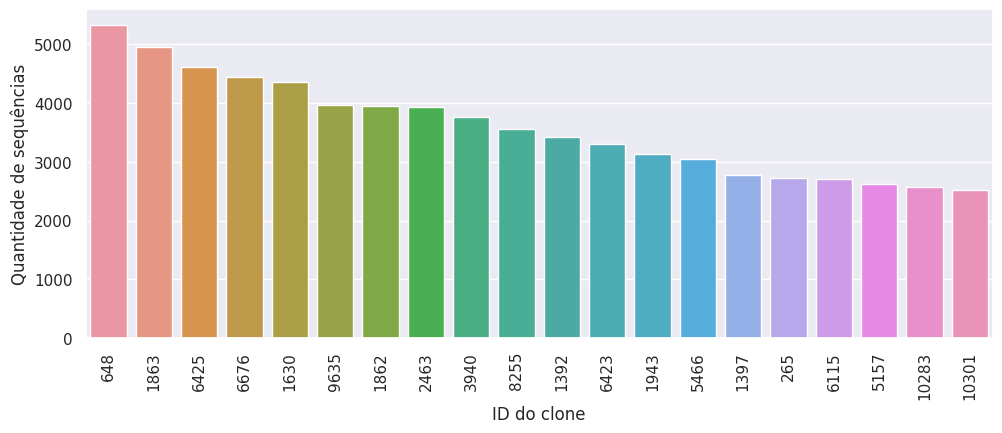

In [78]:
sns.set(rc={'figure.figsize':(11.7,4.27)})

ax = sns.barplot(x=clones['clone_id'].astype(str).value_counts().sort_values(ascending=False).head(20).index,
            y=clones['clone_id'].astype(str).value_counts().sort_values(ascending=False).head(20))
ax.set(xlabel='ID do clone', ylabel='Quantidade de sequências')

plt.xticks(rotation=90)
plt.show()

In [ ]:
amino_acids = {
    'TTT': 'F',
    'TTC': 'F',
    'TTA': 'L',
    'TTG': 'L',
    'TCT': 'S',
    'TCC': 'S',
    'TCA': 'S',
    'TCG': 'S',
    'TAT': 'Y',
    'TAC': 'Y',
    'TAA': 'Stop',
    'TAG': 'Stop',
    'TGT': 'C',
    'TGC': 'C',
    'TGA': 'Stop',
    'TGG': 'W',
    'CTT': 'L',
    'CTC': 'L',
    'CTA': 'L',
    'CTG': 'L',
    'CCT': 'P',
    'CCC': 'P',
    'CCA': 'P',
    'CCG': 'P',
    'CAT': 'H',
    'CAC': 'H',
    'CAA': 'Q',
    'CAG': 'Q',
    'CGT': 'R',
    'CGC': 'R',
    'CGA': 'R',
    'CGG': 'R',
    'ATT': 'I',
    'ATC': 'I',
    'ATA': 'I',
    'ATG': 'M',
    'ACT': 'T',
    'ACC': 'T',
    'ACA': 'T',
    'ACG': 'T',
    'AAT': 'N',
    'AAC': 'N',
    'AAA': 'K',
    'AAG': 'K',
    'AGT': 'S',
    'AGC': 'S',
    'AGA': 'R',
    'AGG': 'R',
    'GTT': 'V',
    'GTC': 'V',
    'GTA': 'V',
    'GTG': 'V',
    'GCT': 'A',
    'GCC': 'A',
    'GCA': 'A',
    'GCG': 'A',
    'GAT': 'D',
    'GAC': 'D',
    'GAA': 'E',
    'GAG': 'E',
    'GGT': 'G',
    'GGC': 'G',
    'GGA': 'G',
    'GGG': 'G'
}

In [77]:
amino_acids_list = []

for row in clones.iloc:
    for aa in re.findall('...', row.cdr3):
        amino_acids_list.append(amino_acids[aa])
amino_acids_list[:50]

['G',
 'R',
 'D',
 'E',
 'D',
 'L',
 'L',
 'G',
 'R',
 'F',
 'F',
 'G',
 'N',
 'G',
 'R',
 'D',
 'E',
 'D',
 'L',
 'L',
 'G',
 'R',
 'F',
 'F',
 'G',
 'N',
 'G',
 'R',
 'D',
 'E',
 'D',
 'L',
 'L',
 'G',
 'R',
 'F',
 'F',
 'G',
 'N',
 'G',
 'R',
 'D',
 'E',
 'D',
 'L',
 'L',
 'G',
 'R',
 'F',
 'F']

In [76]:
amino_acids_series = pd.Series(amino_acids_list, copy=False)
amino_acids_series.value_counts(normalize=True).head(30)

G       0.375050
D       0.124849
Y       0.124849
T       0.124723
F       0.124647
E       0.124647
A       0.000378
L       0.000202
S       0.000176
K       0.000101
C       0.000076
N       0.000076
Stop    0.000050
H       0.000050
I       0.000050
V       0.000050
R       0.000025
Name: proportion, dtype: float64

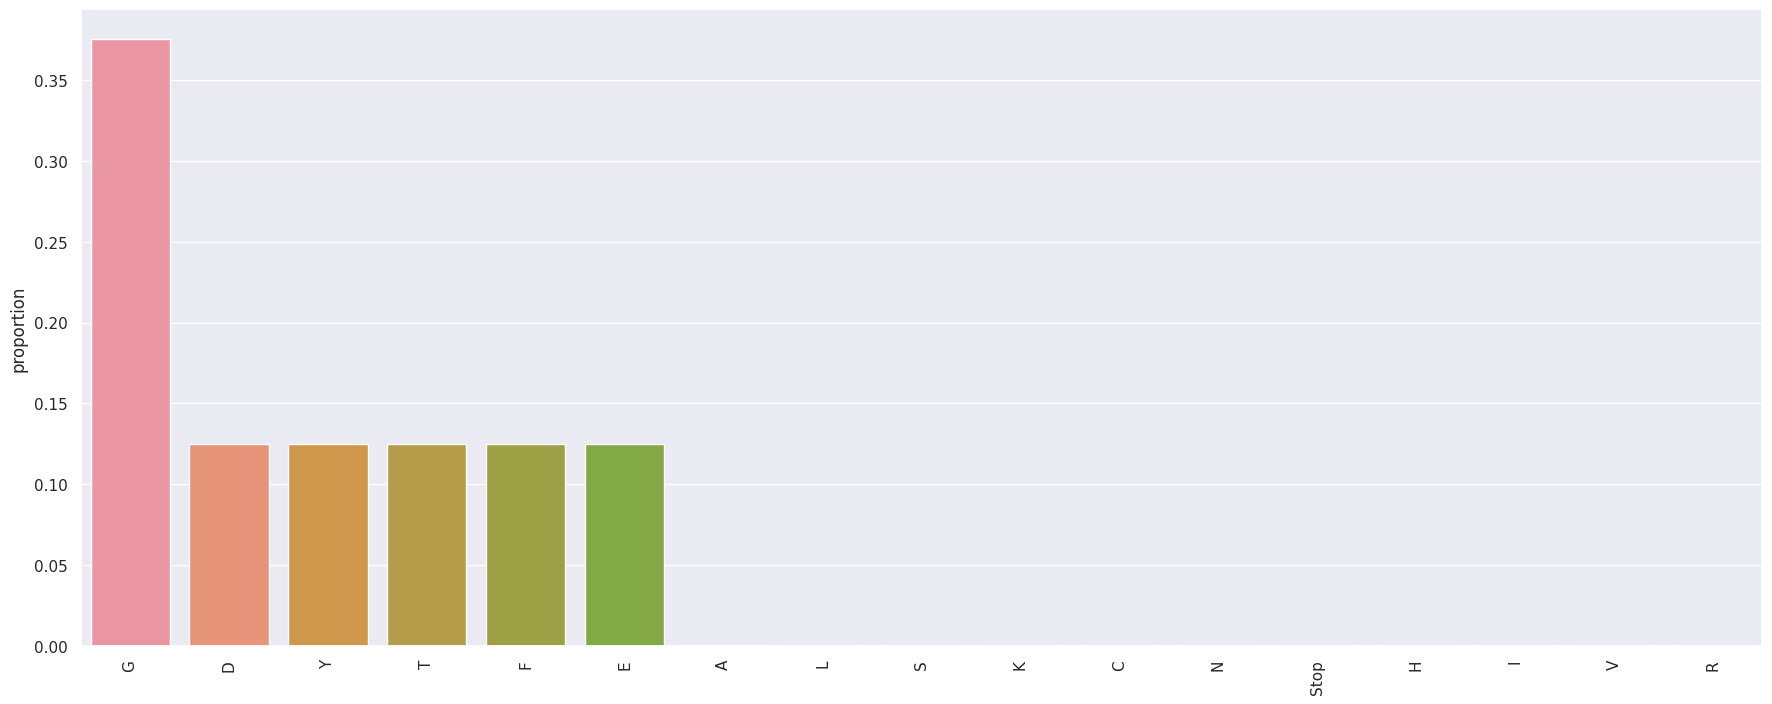

In [75]:
amino_acids_series = pd.Series(amino_acids_list, copy=False)
sns.set(rc={'figure.figsize':(21.7,8.27)})

sns.barplot(x=amino_acids_series.value_counts(normalize=True).head(50).index,
            y=amino_acids_series.value_counts(normalize=True).head(50))
plt.xticks(rotation=90)
plt.show()

<div class="alert alert-block alert-info">
    - Realizar essa última analise só com as produtivas
</div>

# Análises com o maior clone

### Frequência de combinação V(D)J no maior clone

In [74]:
aux = clones['clone_id'].value_counts().sort_values(ascending=False)
largest_clone = clones[clones['clone_id'] == aux.index[0]]
largest_clone

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,clone_id,d_frame,seqorient,cprimer,vprimer
39147,M02832:47:000000000-K3JFG:1:2119:13548:25290|SEQO,GTGTCCTGTCCCAGGTGCAACTGCAGGAGTGGGGCCCAGGACTGGT...,T,T,Equcab IGHV4-65*01 F,Equcab IGHD2-26*01 F,Equcab IGHJ4*01 F,CAGGTGCAACTGCAGGAGTGGGGCCCA...GGACTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATGCTTATGCTGGAACTGCGTATGACCAATTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
39148,M02832:47:000000000-K3JFG:1:2119:9949:25012|SE...,GTGTCCTGTCCCAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGT...,T,T,Equcab IGHV4-65*01 F,Equcab IGHD2-26*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATGCTTATGCTGGAACTGCGTATGACCAATTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
39149,M02832:47:000000000-K3JFG:1:2119:12286:24959|S...,GAGTCCTCTCCCAGGTGAAGCTGCAGGAGTCGGGCCCAGGTCTGGT...,T,T,Equcab IGHV4-65*01 F,Equcab IGHD2-26*01 F,Equcab IGHJ4*01 F,CAGGTGAAGCTGCAGGAGTCGGGCCCA...GGTCTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATGCTTATGCTGGAACTGCGTATGACCAATTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
39150,M02832:47:000000000-K3JFG:1:2119:22734:23682|S...,GTGTCCTGTCCCAGGTGAAGCTGCAGGAGTGGGGCCCAGGACTGGT...,T,T,Equcab IGHV4-65*01 F,Equcab IGHD2-26*01 F,Equcab IGHJ4*01 F,CAGGTGAAGCTGCAGGAGTGGGGCCCA...GGACTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATGCTTATGCTGGAACTGCGTATGACCAATTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
39151,M02832:47:000000000-K3JFG:1:2119:26292:22113|S...,GTGTCCTGTCCCAGGTGCAGCTGCAGGAGTGGGGCCCAGGACTGGT...,T,T,Equcab IGHV4-65*01 F,Equcab IGHD2-26*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGCAGGAGTGGGGCCCA...GGACTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATGCTTATGCTGGAACTGCGTATGACCAATTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44475,M02832:47:000000000-K3JFG:1:1103:16414:19016|S...,GTGTCCTGTCCCAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGT...,T,T,Equcab IGHV4-65*01 F,Equcab IGHD2-3*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTACAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATCCTTATGCCGGAACTCTCTATGACACCTTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
44476,M02832:47:000000000-K3JFG:1:1102:25815:20359|S...,GTGTCCTGTCCCAGGTGCAGCTGCAGGAGTCGGGCCCGGGACTGGT...,T,T,Equcab IGHV4-65*01 F,Equcab IGHD2-23*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGCAGGAGTCGGGCCCG...GGACTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATCCCTATGCTGGTATTCTCGATTCCTCCTTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
44477,M02832:47:000000000-K3JFG:1:1101:7565:20039|SE...,GTGTCTCCTCCGAGGTTCAGCTGCAGGAGTCGGGCCCGGGACTGGT...,F,T,Equcab IGHV4-65*01 F,Equcab IGHD2-18*01 F,Equcab IGHJ4*01 F,GAGGTTCAGCTGCAGGAGTCGGGCCCG...GGACTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCCAATGCTTATCCTGGTATTCGCGATGCCCGCTTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN
44478,M02832:47:000000000-K3JFG:1:1101:19896:17557|S...,GTGTCTCCTCCGAGGTCCAGCTGCAGGAGTCGGGCCCGGGACTGGT...,F,T,Equcab IGHV4-65*01 F,Equcab IGHD2-36*01 F,Equcab IGHJ4*01 F,GAGGTCCAGCTGCAGGAGTCGGGCCCG...GGACTGGTGCAGCCCT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGCAGCCCT...,TGTGCAAATCCTTATGCTGGCATTCTCGATTCCTCCTTCCTCCCCT...,...,0,0,0,0,NaN,648,3.0,NaN,NaN,NaN


In [73]:
aux = clones['clone_id'].value_counts().sort_values(ascending=False)
sec_largest_clone = clones[clones['clone_id'] == aux.index[1]]
sec_largest_clone

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,p3v_length,p5d_length,p3d_length,p5j_length,duplicate_count,clone_id,d_frame,seqorient,cprimer,vprimer
131676,M02832:47:000000000-K3JFG:1:2119:12390:25123|S...,GAGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,F,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-16*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATTTTGAAGGCTGG,...,0,0,0,0,NaN,1863,2.0,NaN,NaN,NaN
131677,M02832:47:000000000-K3JFG:1:2119:19013:24760|SEQO,GTGTCCTGTCCCAGGTGCAACTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-16*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATTTTGAAGGCTGG,...,0,0,0,0,NaN,1863,2.0,NaN,NaN,NaN
131678,M02832:47:000000000-K3JFG:1:2119:19011:24778|SEQO,GTGTCCTGTCCCAGGTGCAACTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-16*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATTTTGAAGGCTGG,...,0,0,0,0,NaN,1863,2.0,NaN,NaN,NaN
131679,M02832:47:000000000-K3JFG:1:2119:20446:23793|S...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCCGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-16*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCC...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATTTTGAAGGCTGG,...,0,0,0,0,NaN,1863,2.0,NaN,NaN,NaN
131680,M02832:47:000000000-K3JFG:1:2119:18005:23771|SEQO,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-16*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATTTTGAAGGCTGG,...,0,0,0,0,NaN,1863,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136629,M02832:47:000000000-K3JFG:1:1105:23429:12843|S...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-24*02 ORF,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATATTGAAGGCTGG,...,0,0,0,0,NaN,1863,2.0,NaN,NaN,NaN
136630,M02832:47:000000000-K3JFG:1:1105:3511:12686|SE...,GTGTCCTCTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD3-16*01 ORF,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGTGATTATTTTGAAGTCTGG,...,0,0,0,0,NaN,1863,2.0,NaN,NaN,NaN
136631,M02832:47:000000000-K3JFG:1:1104:10820:6200|SE...,GTGTCCTCTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD2-26*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGGAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGATTATTATGAAGGCTGG,...,0,0,0,0,NaN,1863,3.0,NaN,NaN,NaN
136632,M02832:47:000000000-K3JFG:1:1104:19909:4265|SE...,GTGTCCTGTCCCAGGTGCAGCTGAAGGAGTCAGGACCTGGCCTGGT...,T,T,"Equcab IGHV4-29*01 F,Equcab IGHV4-82*01 F",Equcab IGHD6-34*01 F,Equcab IGHJ4*01 F,CAGGTGCAGCTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,CAGGTGCAACTGAAGGAGTCAGGACCT...GGCCTGGTGAAGCCCT...,TGTACAGGAGGGGTTTATTTTGAAGGCTGG,...,0,0,0,0,NaN,1863,3.0,NaN,NaN,NaN


In [72]:
len(largest_clone.iloc[1].cdr3)

57

In [71]:
len(sec_largest_clone.iloc[1].cdr3)

24

In [97]:
count_vdj_use_clone = largest_clone[['v_call', 'd_call', 'j_call']].dropna()
count_vdj_use_clone['v_call'] = count_vdj_use_clone['v_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use_clone['d_call'] = count_vdj_use_clone['d_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use_clone['j_call'] = count_vdj_use_clone['j_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use_clone = count_vdj_use_clone.apply('|'.join, axis=1)
count_vdj_use_clone.value_counts(normalize=True)

Equcab IGHV4-65|Equcab IGHD2-18|Equcab IGHJ4    0.571723
Equcab IGHV4-65|Equcab IGHD2-26|Equcab IGHJ4    0.244140
Equcab IGHV4-65|Equcab IGHD2-23|Equcab IGHJ4    0.080068
Equcab IGHV4-65|Equcab IGHD2-36|Equcab IGHJ4    0.055503
Equcab IGHV4-65|Equcab IGHD7-33|Equcab IGHJ4    0.024564
Equcab IGHV4-65|Equcab IGHD3-27|Equcab IGHJ4    0.012938
Equcab IGHV4-65|Equcab IGHD3-10|Equcab IGHJ4    0.004875
Equcab IGHV4-65|Equcab IGHD2-12|Equcab IGHJ4    0.001688
Equcab IGHV4-65|Equcab IGHD2-3|Equcab IGHJ4     0.001500
Equcab IGHV4-65|Equcab IGHD4-35|Equcab IGHJ4    0.000375
Equcab IGHV4-65|Equcab IGHD4-11|Equcab IGHJ4    0.000375
Equcab IGHV4-65|Equcab IGHD2-21|Equcab IGHJ4    0.000375
Equcab IGHV4-65|Equcab IGHD2-29|Equcab IGHJ4    0.000375
Equcab IGHV4-65|Equcab IGHD3-22|Equcab IGHJ4    0.000375
Equcab IGHV4-65|Equcab IGHD3-7|Equcab IGHJ4     0.000375
Equcab IGHV4-65|Equcab IGHD3-16|Equcab IGHJ4    0.000188
Equcab IGHV4-65|Equcab IGHD3-30|Equcab IGHJ4    0.000188
Equcab IGHV4-65|Equcab IGHD2-39

In [98]:
count_vdj_use_clone_2 = sec_largest_clone[['v_call', 'd_call', 'j_call']].dropna()
count_vdj_use_clone_2['v_call'] = count_vdj_use_clone_2['v_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use_clone_2['d_call'] = count_vdj_use_clone_2['d_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use_clone_2['j_call'] = count_vdj_use_clone_2['j_call'].str.replace(r'\*.*', '', regex=True)
count_vdj_use_clone_2 = count_vdj_use_clone_2.apply('|'.join, axis=1)
count_vdj_use_clone_2.value_counts(normalize=True)

Equcab IGHV4-29|Equcab IGHD3-16|Equcab IGHJ4    0.936668
Equcab IGHV4-21|Equcab IGHD3-22|Equcab IGHJ4    0.036305
Equcab IGHV4-22|Equcab IGHD3-16|Equcab IGHJ4    0.005849
Equcab IGHV4-29|Equcab IGHD2-26|Equcab IGHJ4    0.005849
Equcab IGHV4-82|Equcab IGHD3-16|Equcab IGHJ4    0.003630
Equcab IGHV4-29|Equcab IGHD2-3|Equcab IGHJ4     0.003227
Equcab IGHV4S1|Equcab IGHD2-3|Equcab IGHJ4      0.002219
Equcab IGHV4-29|Equcab IGHD4-38|Equcab IGHJ4    0.001412
Equcab IGHV4-29|Equcab IGHD3-24|Equcab IGHJ4    0.001210
Equcab IGHV4-29|Equcab IGHD3-13|Equcab IGHJ4    0.001008
Equcab IGHV4-29|Equcab IGHD3-40|Equcab IGHJ4    0.000605
Equcab IGHV4-29|Equcab IGHD6-44|Equcab IGHJ4    0.000403
Equcab IGHV4-29|Equcab IGHD6-34|Equcab IGHJ4    0.000403
Equcab IGHV4-82|Equcab IGHD2-3|Equcab IGHJ4     0.000403
Equcab IGHV4-29|Equcab IGHD3-19|Equcab IGHJ4    0.000202
Equcab IGHV4-22|Equcab IGHD2-3|Equcab IGHJ4     0.000202
Equcab IGHV4-82|Equcab IGHD3-22|Equcab IGHJ4    0.000202
Equcab IGHV4-22|Equcab IGHD2-26

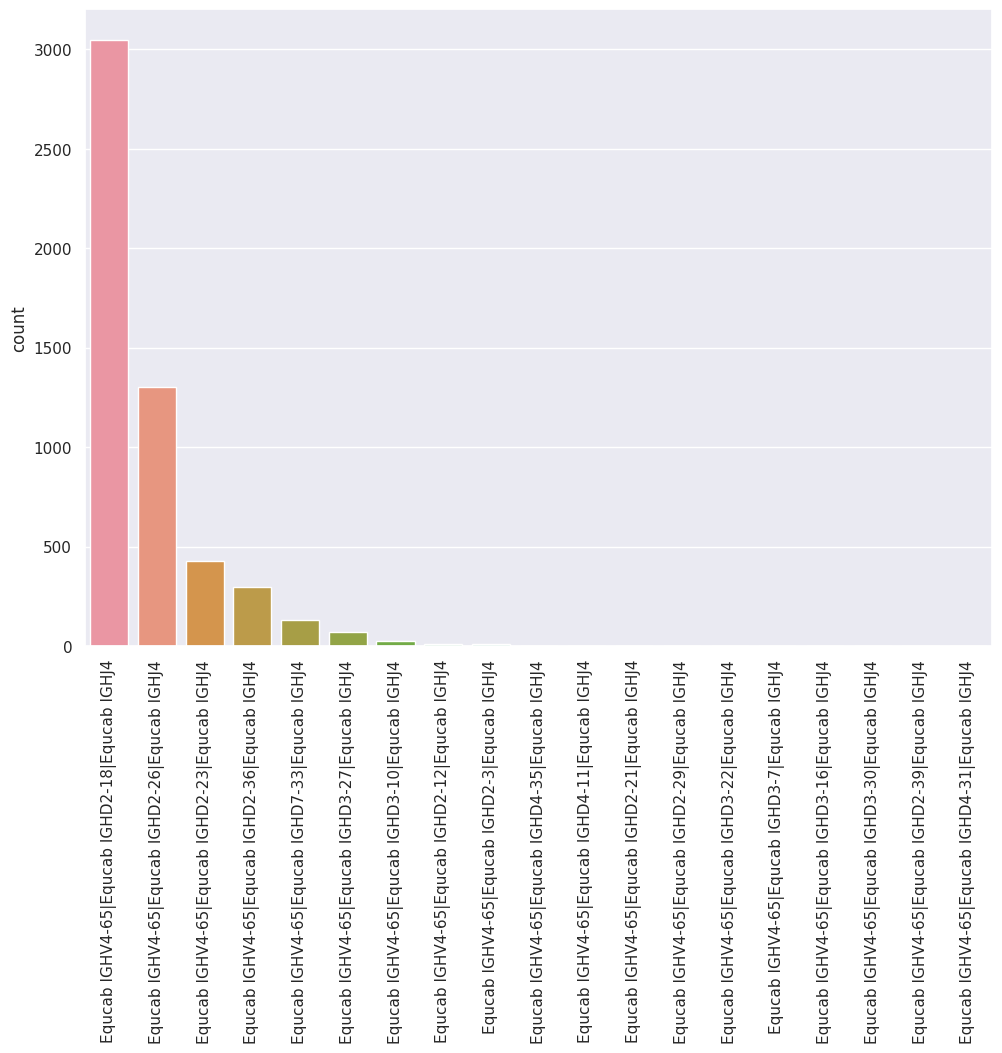

In [99]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x=count_vdj_use_clone.value_counts().head(20).index,
            y=count_vdj_use_clone.value_counts().head(20))
plt.xticks(rotation=90)
plt.show()

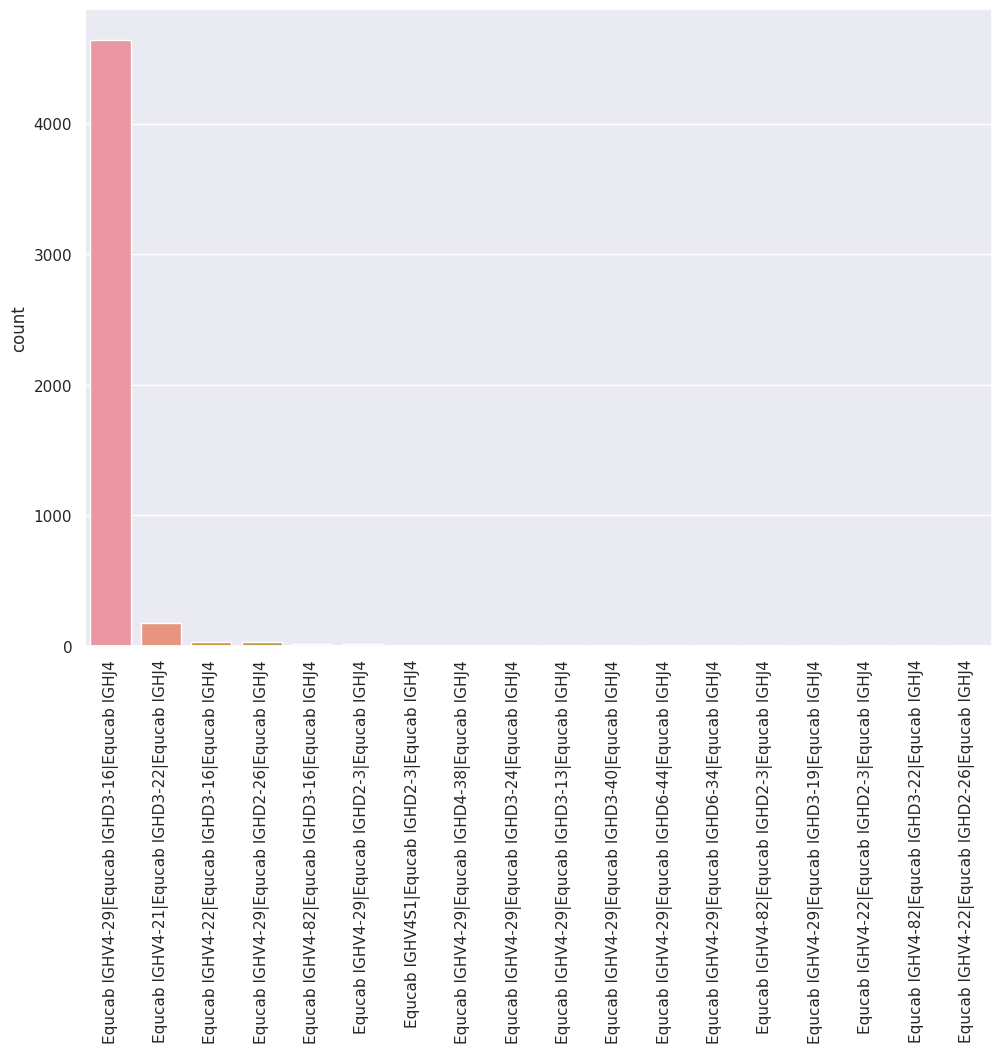

In [100]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x=count_vdj_use_clone_2.value_counts().head(20).index,
            y=count_vdj_use_clone_2.value_counts().head(20))
plt.xticks(rotation=90)
plt.show()

### Aminoácidos mais utilizados no CDR3

In [93]:
largest_clone['cdr3_len'] = largest_clone['cdr3'].apply(lambda x: len(x))
largest_clone['cdr3_len'].describe()

/tmp/ipykernel_11706/2835561796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  largest_clone['cdr3_len'] = largest_clone['cdr3'].apply(lambda x: len(x))


count    5333.0
mean       57.0
std         0.0
min        57.0
25%        57.0
50%        57.0
75%        57.0
max        57.0
Name: cdr3_len, dtype: float64

In [ ]:
amino_acids_list = []
for row in largest_clone.iloc:
    for aa in re.findall('...', row.cdr3):
        amino_acids_list.append(amino_acids[aa])
amino_acids_list[:50]

In [94]:
amino_acids_series = pd.Series(amino_acids_list, copy=False)
amino_acids_series.value_counts(normalize=True).head(30)

G       0.177149
Y       0.149947
A       0.086181
D       0.080542
S       0.070301
V       0.056235
T       0.045226
L       0.043181
F       0.040923
N       0.040856
I       0.037521
R       0.037336
W       0.028870
E       0.027607
P       0.022601
H       0.016633
M       0.012770
K       0.012645
Q       0.008868
C       0.003823
Stop    0.000787
Name: proportion, dtype: float64

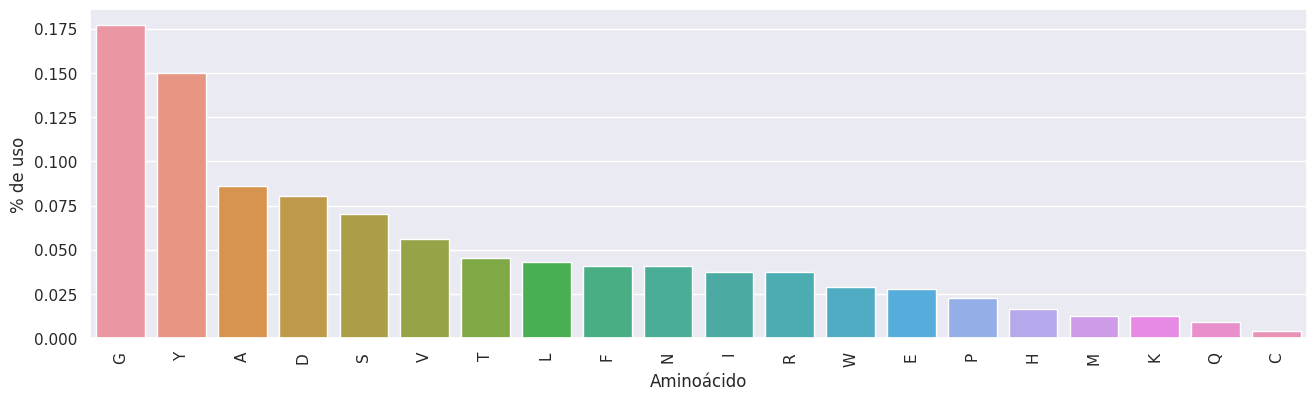

In [95]:
amino_acids_series = pd.Series(amino_acids_list, copy=False)
sns.set(rc={'figure.figsize':(15.7,4.27)})

ax = sns.barplot(x=amino_acids_series.value_counts(normalize=True).head(50).drop(labels=['Stop']).index,
            y=amino_acids_series.value_counts(normalize=True).head(50).drop(labels=['Stop']))
ax.set(xlabel='Aminoácido', ylabel='% de uso')

plt.xticks(rotation=90)
plt.show()

**Segundo Clone**

In [96]:
sec_largest_clone['cdr3_len'] = sec_largest_clone['cdr3'].apply(lambda x: len(x))
sec_largest_clone['cdr3_len'].describe()

/tmp/ipykernel_11706/3850174887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sec_largest_clone['cdr3_len'] = sec_largest_clone['cdr3'].apply(lambda x: len(x))


count    4958.0
mean       24.0
std         0.0
min        24.0
25%        24.0
50%        24.0
75%        24.0
max        24.0
Name: cdr3_len, dtype: float64

In [101]:
amino_acids_list = []
for row in sec_largest_clone.iloc:
    for aa in re.findall('...', row.cdr3):
        amino_acids_list.append(amino_acids[aa])
amino_acids_series = pd.Series(amino_acids_list, copy=False)
amino_acids_series.value_counts(normalize=True).head(30)

G       0.375050
D       0.124849
Y       0.124849
T       0.124723
F       0.124647
E       0.124647
A       0.000378
L       0.000202
S       0.000176
K       0.000101
C       0.000076
N       0.000076
Stop    0.000050
H       0.000050
I       0.000050
V       0.000050
R       0.000025
Name: proportion, dtype: float64

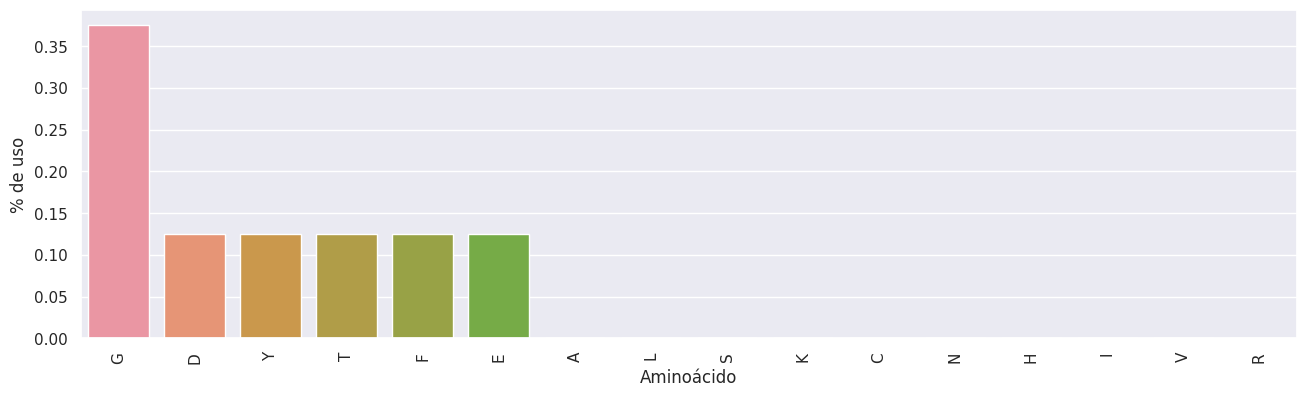

In [102]:
amino_acids_series = pd.Series(amino_acids_list, copy=False)
sns.set(rc={'figure.figsize':(15.7,4.27)})

ax = sns.barplot(x=amino_acids_series.value_counts(normalize=True).head(50).drop(labels=['Stop']).index,
            y=amino_acids_series.value_counts(normalize=True).head(50).drop(labels=['Stop']))
ax.set(xlabel='Aminoácido', ylabel='% de uso')

plt.xticks(rotation=90)
plt.show()

O método de modelo de mistura (method="gmm") é usado para encontrar o limite ideal para separar sequências clonalmente relacionadas ajustando duas distribuições gama (model="gamma-gamma"). 
### Encontre o limite usando o método gmm

- Output1 <- findThreshold(dist_ham$dist_nearest, method="gmm", model="gamma-gamma")  
[1] "Error: No fit found"

### Rarefação
- library(dplyr)  
Para importar o arquivo para o ambiente R    
- teste<-read.table("changeo-db_db-pass_clone-pass.tsv", header = TRUE, sep = "\t", quote = "", dec = ".", fill = TRUE, comment.char = "")  
Devemos adicionar o conteúdo da coluna de contagem de duplicados para saber quantos clones temos  
- sum(teste\\$duplicate_count)  
[1]  NA    
Os dados são estendidos levando em consideração as sequências que foram duplicadas no pré-processamento  
- teste.ex<-teste[rep(row.names(teste),teste\\$duplicate_count),50:51]  
O seguinte é adicionar os dados estendidos e colocar uma nova coluna  
- teste.ex<-add_count(teste.ex, clone_id)  
Uma nova data é feito, eliminando os clones que estão duplicados  
- testeclon<-teste.ex\[!duplicated(teste.ex[c("clone_id")]),]  
Fazemos uma nova data selecionando apenas as colunas que precisamos para a rarefação  
- testerare<-testeclon[, c("n", "clone_id")]  
Mudamos o nome da coluna  
- names(testerare)<-c("rare", "clone_id")  
A coluna rara é convertida em um vetor, pois a biblioteca exige isso  
- as.vector(testerare$rare)  
O número de sequências por clone é ordenado do maior para o menor.  
- testerare<-testerare\\$rare\[order(testerare\\$rare,decreasing = TRUE)] 

- install.packages("iNEXT") (so 1 vez)  
- library(iNEXT)  
- library(ggplot2)  
Verifique o cabeçalho do arquivo:  
- head(testerare)  
[1] 13962 11694  6761  4603  3941  3684
- Verifique a última parte do arquivo pois não tem o mesmo tamanho  
- tail(testerare)  
[1] 1 1 1 1 1 1.  

Mude "na" por "0" para que as colunas sejam iguais  
- testerare[is.na(testerare)] <- 0  
Verifique o final do arquivo novamente  
- tail(testerare)  
[1] 1 1 1 1 1 1.  
INEXT para abundacidade  
- raretotal1 <- iNEXT(testerare, q=0, datatype="abundance")  
- head(raretotal1)

### PARA EXPORTAR DADOS
Primeiro você deve convertê-lo em dados em um data.frame:  
- rarefacao_diversidade=as.data.frame.matrix(raretotal1[["AsyEst"]])  
  
Depois disso é exportado em formato .csv:  
- write.csv(rarefacao_diversidade,"rarefacao_diversidade.csv")  


In [ ]:
rarefacao = pd.read_table(outdir +"/presto/rarefacao_diversidade.csv")
pd.set_option('display.max_columns', None)
rarefacao.describe

### PARA FAZER A FIGURA

- tiff('teste-rarefacao.tiff', units="in", width=5, height=3, res=1200, compression = 'lzw')  
  
- g <- ggiNEXT(raretotal1, type = 1, color.var = "Order.q") +   
  theme(  
    axis.title.x = element_text(size = 12, family = "Arial", face = "bold", colour = "black"),  
    axis.title.y = element_text(size = 12, family = "Arial", face = "bold", colour = "black"),  
    axis.text.x = element_text(family = "arial", face = "bold", size = 12, colour = "black"),  
    axis.text.y = element_text(family = "arial", face = "bold", size = 12, colour = "black"),  
    legend.position = 'none'  
  ) +  
  xlab("Productive reads") +  
  ylab("Species richness") +  
  scale_shape_manual(values = c(1, 2, 3, 4)) +  
  theme_classic(base_size = 13)  
- g  
- dev.off()

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread(outdir + "/presto/teste-rarefacao.tiff")
plt.imshow(img)
plt.axis('off')  
plt.show()